# Generating Distractors for Questions

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

from datetime import datetime

# Exploratory Data Analysis

## Data Loading and Cleaning

In [2]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)

In [3]:
df = pd.read_csv('Train.csv')

print("Number of data points:",df.shape[0])

Number of data points: 31499


In [4]:
df.head()

,question,answer_text,distractor
0,Meals can be served,in rooms at 9:00 p. m.,"'outside the room at 3:00 p. m.', 'in the dini..."
1,It can be inferred from the passage that,The local government can deal with the problem...,"'If some tragedies occur again ', ' relevant d..."
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"'blame Tommy for his failing grades', 'blame T..."
3,It can be inferred from the passage that,the writer is not very willing to use idioms,'idioms are the most important part in a langu...
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,'Cut the wound and suck the poison out .'


## Count the number of distractor per question

In [5]:
start = datetime.now()
df["distractor_count"] = df["distractor"].apply(lambda text: len(text.split(",")))

# adding a new feature number of distractor per question
print("Time taken to run this cell :", datetime.now() - start)

df.head()

Time taken to run this cell : 0:00:00.084007


,question,answer_text,distractor,distractor_count
0,Meals can be served,in rooms at 9:00 p. m.,"'outside the room at 3:00 p. m.', 'in the dini...",3
1,It can be inferred from the passage that,The local government can deal with the problem...,"'If some tragedies occur again ', ' relevant d...",5
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"'blame Tommy for his failing grades', 'blame T...",2
3,It can be inferred from the passage that,the writer is not very willing to use idioms,'idioms are the most important part in a langu...,3
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,'Cut the wound and suck the poison out .',1


In [6]:
df.distractor_count.value_counts()

3     11657
1      9151
2      8753
4      1219
5       318
6       290
7        41
8        26
9        23
12       10
10        7
15        2
29        1
11        1
Name: distractor_count, dtype: int64

## Droping the rows which have more than 4 distractors

In [7]:
df.drop(df[df['distractor_count'] > 4].index, inplace = True)
df.distractor_count.value_counts()

3    11657
1     9151
2     8753
4     1219
Name: distractor_count, dtype: int64

In [8]:
df.shape

(30780, 4)

In [9]:
df.head()

,question,answer_text,distractor,distractor_count
0,Meals can be served,in rooms at 9:00 p. m.,"'outside the room at 3:00 p. m.', 'in the dini...",3
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"'blame Tommy for his failing grades', 'blame T...",2
3,It can be inferred from the passage that,the writer is not very willing to use idioms,'idioms are the most important part in a langu...,3
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,'Cut the wound and suck the poison out .',1
5,What was the writer 's problem when she studie...,She missed her family very much .,"""She did n't like her new school ."", ""She did ...",3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30780 entries, 0 to 31498
Data columns (total 4 columns):
question            30780 non-null object
answer_text         30780 non-null object
distractor          30780 non-null object
distractor_count    30780 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


## Cleaning Data

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
df['distractor'] = df['distractor'].apply(lambda x: clean_text(x))

### Checking missing value

Text(0.5, 1.0, 'Ratio of missing values per columns')

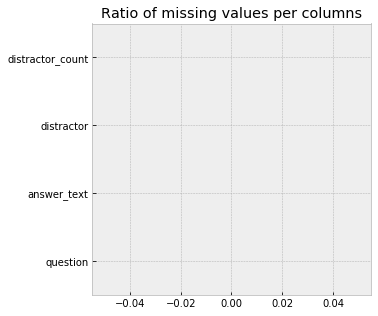

In [13]:
plt.figure(figsize=(5, 5))
df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

## Checking Duplicate Entries

In [14]:
print('Dupplicate entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values

## Count how many distractors are there

In [15]:
df['distractor'] = df['distractor'].apply(lambda x: x.split(','))
all_distractors = [item for sublist in df['distractor'].values for item in sublist]
len(all_distractors)

66504

In [16]:
df.shape

(30780, 4)

## Count how many Unique distractors are there

In [17]:
my_set = set(all_distractors)
unique_distractors = list(my_set)
len(unique_distractors)

65382

In [18]:
flat_list = [item for sublist in df['distractor'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(13000)
distractors_features = [word[0] for word in frequencies_words]

In [19]:
distractors_features = distractors_features[2:]
distractors_features

[" ' too'",
 "'a friend in need is a friend indeed'",
 "'in fact '",
 "'no '",
 "'yes '",
 " '000'",
 "'children'",
 " 'water pollution'",
 "are d'",
 " 'in the past '",
 "'children .'",
 "'chinese'",
 " are member things easily'",
 " ' twice shy'",
 " '000 years ago .'",
 " 'warn against the damage of locking the baggage'",
 "'english'",
 " pace travel'",
 "'women are socially trained to talk'",
 " 'about 100 years ago people ran or jumped when they played'",
 " ' london kiss .'",
 "'old people'",
 '"man life will be different in the future"',
 "'touching by feeling'",
 " 'ways of feeling'",
 "'the bears will be missed'",
 " ' china .'",
 "'are easily found by birds'",
 "'how to make friends .'",
 " ' either'",
 " '000 .'",
 "tudents'",
 "'effendi killed him'",
 ' " i do not know ."',
 "'water pollution'",
 " 'help children to learn english'",
 "'good'",
 " 'in america '",
 " 'their driving with passengers'",
 "'all the things you can see give off light .'",
 "'chinese food'",
 " '000

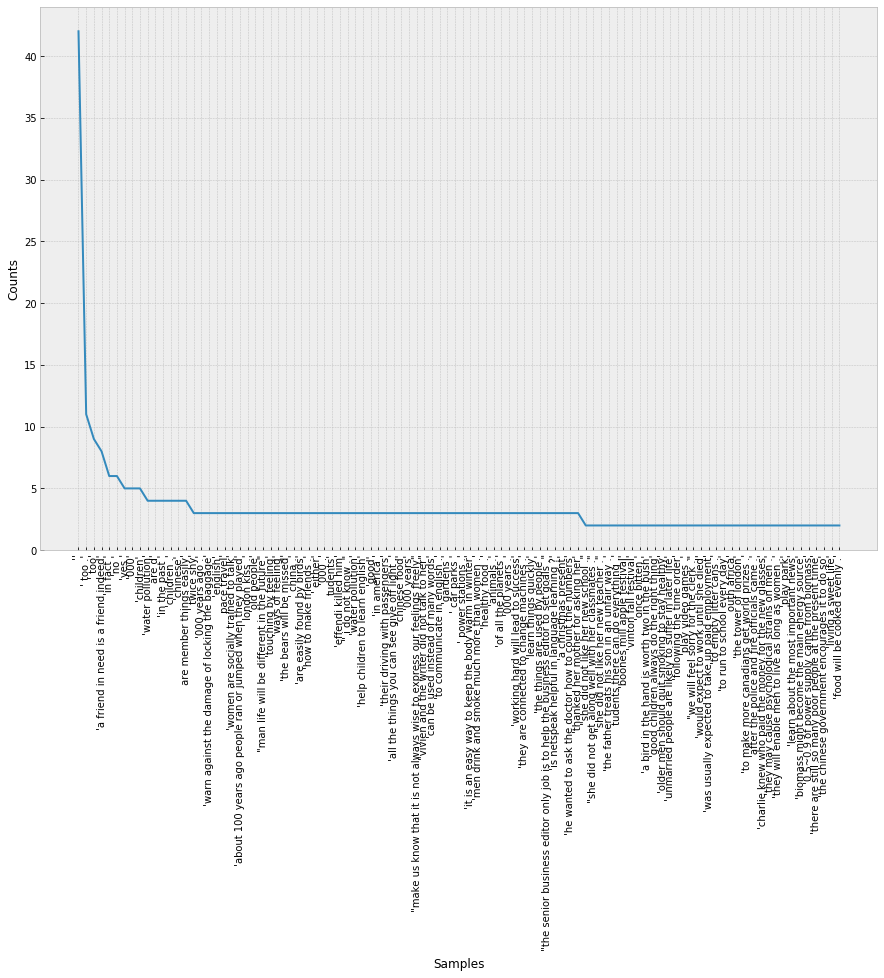

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [21]:
# # Importing & Initializing the "CountVectorizer" object, which 
# #is scikit-learn's bag of words tool.

# #by default 'split()' will tokenize each tag using space.
# vectorizer = CountVectorizer()
# # fit_transform() does two functions: First, it fits the model
# # and learns the vocabulary; second, it transforms our training data
# # into feature vectors. The input to fit_transform should be a list of strings.
# distractor_dtm = vectorizer.fit_transform(distractors_features)

In [22]:
# distractor_dtm

In [23]:
# distractor_dtm.shape

In [24]:
# print("Number of data points :", distractor_dtm.shape[0])
# print("Number of unique tags :", distractor_dtm.shape[1])

In [25]:
# #'get_feature_name()' gives us the vocabulary.
# distractors = vectorizer.get_feature_names()
# #Lets look at the distractors we have.
# print("Some of the distractors we have :", distractors[:10])

## Most common Distractors

In [26]:
def most_common(distractors):
    distractors_filtered = []
    for i in range(0, len(distractors)):
        if distractors[i] in distractors_features:
            distractors_filtered.append(distractors[i])
    return distractors_filtered

In [27]:
df.shape

(30780, 4)

## Number of distractor in the question question

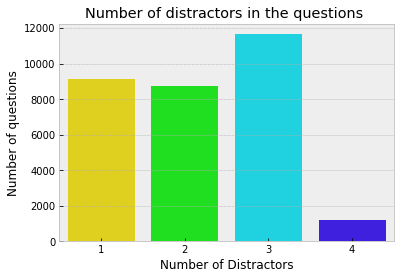

In [28]:
sns.countplot(df.distractor_count, palette='gist_rainbow')
plt.title("Number of distractors in the questions ")
plt.xlabel("Number of Distractors")
plt.ylabel("Number of questions")
plt.show()

# I obseved that the most frequent the distractor has been used is 3, 1 and 2. 

In [29]:
df.drop(columns=['distractor_count'], inplace=True)

In [30]:
df.shape

(30780, 3)

In [31]:
df.head()

,question,answer_text,distractor
0,Meals can be served,in rooms at 9:00 p. m.,"['outside the room at 3:00 p. m.', 'in the di..."
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"['blame tommy for his failing grades', 'blame..."
3,It can be inferred from the passage that,the writer is not very willing to use idioms,['idioms are the most important part in a lang...
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,['cut the wound and suck the poison out .']
5,What was the writer 's problem when she studie...,She missed her family very much .,"[""she did not like her new school ."", ""she di..."


In [32]:
df.distractor[5]

['"she did not like her new school ."',
 ' "she did not get along well with her classmates ."',
 ' "she did not like her new teacher ."']

In [33]:
df.distractor

0        ['outside the room at 3:00 p. m.',  'in the di...
2        ['blame tommy for his failing grades',  'blame...
3        ['idioms are the most important part in a lang...
4              ['cut the wound and suck the poison out .']
5        ["she did not like her new school .",  "she di...
                               ...                        
31494    ['tally brought the doctor to him after the ac...
31495    ['helping put in local libraries',  'working a...
31496    ['little tom is a bad boy .',  'little tom oft...
31497    ['they are in fear of another great depression...
31498    ['he liked go play with herbs .',  'he studied...
Name: distractor, Length: 30780, dtype: object

In [34]:
df['distractor'] = df['distractor'].apply(lambda x: most_common(x))
df['distractor'] = df['distractor'].apply(lambda x: x if len(x)>0 else None)

In [35]:
type(df['distractor'])

pandas.core.series.Series

In [36]:
df.shape

(30780, 3)

In [37]:
df.dropna(subset=['distractor'], inplace=True)

In [38]:
df.shape

(6860, 3)

In [39]:
df.head()

,question,answer_text,distractor
0,Meals can be served,in rooms at 9:00 p. m.,"['outside the room at 3:00 p. m.', 'in the di..."
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"['blame tommy for his failing grades', 'blame..."
3,It can be inferred from the passage that,the writer is not very willing to use idioms,['idioms are the most important part in a lang...
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,['cut the wound and suck the poison out .']
5,What was the writer 's problem when she studie...,She missed her family very much .,"[""she did not like her new school ."", ""she di..."


In [40]:
df.distractor

0        ['outside the room at 3:00 p. m.',  'in the di...
2        ['blame tommy for his failing grades',  'blame...
3        ['idioms are the most important part in a lang...
4              ['cut the wound and suck the poison out .']
5        ["she did not like her new school .",  "she di...
                               ...                        
31385                               ['effendi killed him']
31425    [uccess is the result of hard work',  'working...
31435          ['long distances',  'fresh and tasty food']
31456        ['you can be sure that you get real friends']
31466    ['giving means you will lack money',  'the exc...
Name: distractor, Length: 6860, dtype: object

In [41]:
token=ToktokTokenizer()

In [42]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [43]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [44]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [45]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in distractors_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [46]:
df['question'] = df['question'].apply(lambda x: clean_punct(x)) 

In [47]:
df.head()

,question,answer_text,distractor
0,Meals can be served,in rooms at 9:00 p. m.,"['outside the room at 3:00 p. m.', 'in the di..."
2,The author called Tommy s parents in order to,help them realize their influence on Tommy,"['blame tommy for his failing grades', 'blame..."
3,It can be inferred from the passage that,the writer is not very willing to use idioms,['idioms are the most important part in a lang...
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,['cut the wound and suck the poison out .']
5,What was the writer s problem when she studied...,She missed her family very much .,"[""she did not like her new school ."", ""she di..."


In [48]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

In [49]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [50]:
df['question'] = df['question'].apply(lambda x: lemitizeWords(x)) 
df['question'] = df['question'].apply(lambda x: stopWordsRemove(x)) 

In [51]:
df['answer_text'] = df['answer_text'].apply(lambda x: str(x))
df['answer_text'] = df['answer_text'].apply(lambda x: clean_text(x)) 
df['answer_text'] = df['answer_text'].apply(lambda x: clean_punct(x)) 
df['answer_text'] = df['answer_text'].apply(lambda x: lemitizeWords(x)) 
df['answer_text'] = df['answer_text'].apply(lambda x: stopWordsRemove(x)) 

In [52]:
df.head()

,question,answer_text,distractor
0,Meals serve,room 9 00 p,"['outside the room at 3:00 p. m.', 'in the di..."
2,The author call Tommy parent order,help realize influence tommy,"['blame tommy for his failing grades', 'blame..."
3,It infer passage,writer use idioms,['idioms are the most important part in a lang...
4,How deal snake wound accord passage,stay calm move,['cut the wound and suck the poison out .']
5,What writer problem study board school first,miss family much,"[""she did not like her new school ."", ""she di..."


In [53]:
df['text'] = df['question'] +" "+df['answer_text']+" "+df['answer_text']

In [54]:
df.text[2]

'The author call Tommy parent order help realize influence tommy help realize influence tommy'

In [55]:
print("number of data points in sample :", df.shape[0])
print("number of dimensions :", df.shape[1])

number of data points in sample : 6860
number of dimensions : 4


# Machine Learning Models

In [56]:
no_topics = 30

In [57]:
text = df['text']

In [58]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [59]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [60]:
TF_IDF_matrix

<6860x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 48231 stored elements in Compressed Sparse Row format>

In [61]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [62]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
special light clothe choose listen wear mrs concern 30 camp
--------------------------------------------
--------------------------------------------
Topic 1:
book friends read history interest watch tv effect kid many
--------------------------------------------
--------------------------------------------
Topic 2:
top england stand industry among higher education five public uk
--------------------------------------------
--------------------------------------------
Topic 3:
friend park go car face night room let sense national
--------------------------------------------
--------------------------------------------
Topic 4:
cook rich farm australia anything voice why writer agree food
--------------------------------------------
--------------------------------------------
Topic 5:
years train bear plan around five every kill later carry
--------------------------------------------
--------------------------------------------
Top

# PART 2: Classical classifiers

In [63]:
X1 = df['answer_text']
X2 = df['question']
# X3 = df.text
y = df['distractor']

In [64]:
type(y)

pandas.core.series.Series

In [65]:
y

0        ['outside the room at 3:00 p. m.',  'in the di...
2        ['blame tommy for his failing grades',  'blame...
3        ['idioms are the most important part in a lang...
4              ['cut the wound and suck the poison out .']
5        ["she did not like her new school .",  "she di...
                               ...                        
31385                               ['effendi killed him']
31425    [uccess is the result of hard work',  'working...
31435          ['long distances',  'fresh and tasty food']
31456        ['you can be sure that you get real friends']
31466    ['giving means you will lack money',  'the exc...
Name: distractor, Length: 6860, dtype: object

In [66]:
df

,question,answer_text,distractor,text
0,Meals serve,room 9 00 p,"['outside the room at 3:00 p. m.', 'in the di...",Meals serve room 9 00 p room 9 00 p
2,The author call Tommy parent order,help realize influence tommy,"['blame tommy for his failing grades', 'blame...",The author call Tommy parent order help realiz...
3,It infer passage,writer use idioms,['idioms are the most important part in a lang...,It infer passage writer use idioms writer use ...
4,How deal snake wound accord passage,stay calm move,['cut the wound and suck the poison out .'],How deal snake wound accord passage stay calm ...
5,What writer problem study board school first,miss family much,"[""she did not like her new school ."", ""she di...",What writer problem study board school first m...
6,Who kill February 5 small town near Johannesburg,chen jianqing one partner,"['chen jianqing and her husband', 'chen jingm...",Who kill February 5 small town near Johannesbu...
7,According writer follow statements true,soccer popular world truly great players,['millions of people all over the world are pl...,According writer follow statements true soccer...
8,During fire children often,panic,['know certain steps'],During fire children often panic panic
9,What title passage,five children die kindergarten bus accident,"['a bus accident in deng zhou .', 'all primar...",What title passage five children die kindergar...
10,We feel unhappy,fight classmates,['we get good grades'],We feel unhappy fight classmates fight classmates


In [67]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [68]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [69]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X1.fit_transform(X2)

In [70]:
type(X1_tfidf)

scipy.sparse.csr.csr_matrix

In [71]:
X1_tfidf.shape

(6860, 1000)

In [72]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [73]:
type(X_tfidf)

scipy.sparse.coo.coo_matrix

In [74]:
type(X_tfidf)

scipy.sparse.coo.coo_matrix

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

In [76]:
X_train.shape

(5488, 2000)

In [77]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [78]:
X_test.shape

(1372, 2000)

In [79]:
y_train.shape

(5488, 12998)

In [80]:
y_test.shape

(1372, 12998)

# One vs Rest

In [81]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

In [82]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

# dummy, sgd, lr, mn,
for classifier in [ svc, pac, perceptron,sgd]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  LinearSVC
Jacard score: 6.90597667638484
Hamming loss: 0.015151467572719195
---
Clf:  PassiveAggressiveClassifier
Jacard score: 9.056122448979592
Hamming loss: 0.017585122985953883
---
Clf:  Perceptron
Jacard score: 4.955901003415875
Hamming loss: 0.07805080575302682
---
Clf:  SGDClassifier
Jacard score: 4.160592808551992
Hamming loss: 0.015370160109853186
---


In [83]:
# rfc = RandomForestClassifier()
# rfc.fit(X_train, y_train)

# y_pred = rfc.predict(X_test)

# print_score(y_pred, rfc)

In [84]:
param_grid = {'estimator__C':[1,10,100,1000]}

In [85]:
svc = OneVsRestClassifier(PassiveAggressiveClassifier())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... estimator__C=1, score=5.194, total= 2.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] estimator__C=1 ..................................................
[CV] ...................... estimator__C=1, score=7.872, total= 2.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s


[CV] estimator__C=1 ..................................................
[CV] ...................... estimator__C=1, score=6.671, total= 2.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.9min remaining:    0.0s


[CV] estimator__C=1 ..................................................
[CV] ...................... estimator__C=1, score=7.659, total= 2.8min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.7min remaining:    0.0s


[CV] estimator__C=1 ..................................................
[CV] ...................... estimator__C=1, score=6.999, total= 2.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.5min remaining:    0.0s


[CV] estimator__C=10 .................................................
[CV] ..................... estimator__C=10, score=5.414, total= 2.6min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 16.2min remaining:    0.0s


[CV] estimator__C=10 .................................................
[CV] ..................... estimator__C=10, score=7.761, total= 2.1min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 18.3min remaining:    0.0s


[CV] estimator__C=10 .................................................
[CV] ..................... estimator__C=10, score=6.853, total= 2.3min
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 20.6min remaining:    0.0s


[CV] ..................... estimator__C=10, score=7.613, total= 1.8min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 22.4min remaining:    0.0s


[CV] estimator__C=10 .................................................
[CV] ..................... estimator__C=10, score=7.273, total= 2.4min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=5.247, total= 2.1min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=7.766, total= 2.7min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=6.626, total= 2.4min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=7.621, total= 2.4min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=7.238, total=  52.4s
[CV] estimator__C=1000 ...............................................
[CV] ................... estimator__C=1000, score=5.149, total=  59.6s
[CV] e

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 44.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=OneVsRestClassifier(estimator=PassiveAggressiveClassifier(C=1.0,
                                                                                 average=False,
                                                                                 class_weight=None,
                                                                                 early_stopping=False,
                                                                                 fit_intercept=True,
                                                                                 loss='hinge',
                                                                                 max_iter=1000,
                                                                                 n_iter_no_change=5,
                                                                                 n_jobs=None,
                                                                          

In [86]:
CV_svc.best_params_

{'estimator__C': 10}

In [87]:
best_model = CV_svc.best_estimator_

In [88]:
X_test.shape

(1372, 2000)

In [89]:
type(X_test)

scipy.sparse.csr.csr_matrix

In [90]:
y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)

Clf:  OneVsRestClassifier
Jacard score: 9.250485908649173
Hamming loss: 0.017915965542130947
---


In [91]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

 " 500 people died on titanic maiden voyage in 1912 ."
[[1372]]

 " alan did not realize the fact until years later"
[[1372]]

 " apple iphone 6 is thinner and lighter ."
[[1371    1]
 [   0    0]]

 " but miss white had not realized it at first ."
[[1372]]

 " but now it turned into milky white gradually ."
[[1372]]

 " but now they do not ."
[[1370    1]
 [   0    1]]

 " but still could not speak ."
[[1372]]

 " can the author dreams come true ."
[[1372]]

 " do not do this !"
[[1372]]

 " fooling tricks are applied to the study of animals'behaviors ."
[[1372]]

 " i do not ."
[[1372]]

 " i do not know ."
[[1371    0]
 [   1    0]]

 " it good manners to praise the food before eating ."
[[1372]]

 " it not easy for them to open up ."
[[1372]]

 " it not so hard to boil water ."
[[1372]]

 " it uncertain how to broadcast the spacewalk ."
[[1371    0]
 [   1    0]]

 " light smoke ca not be seen ."
[[1371    0]
 [   1    0]]

 " mobile phones could endanger patients ' lives ."
[[1372

[[1372]]

 "believes that schools ca not teach pupils well"
[[1372]]

 "bill clinton did not accept it"
[[1372]]

 "biology degrees were once hot for those master degree pursuers ."
[[1372]]

 "blackie relaxes under sam chair ."
[[1371    1]
 [   0    0]]

 "blunt father wanted him to have a secure job ."
[[1372]]

 "bob "
[[1372]]

 "bob classmate is wrong ."
[[1372]]

 "bob mother is wrong ."
[[1372]]

 "bolt will not compete in the 200 m in london because of gay impressive times ."
[[1372]]

 "both the dahl frog and the marbled frog protect themselves by producing toxin"
[[1372]]

 "britain poor showing does not lie wholly at the doorstep of britons"
[[1371    0]
 [   1    0]]

 "british men dream of the world cup ."
[[1372]]

 "british people with alzheimer are in poor condition ."
[[1372]]

 "bruce lee showed people chinese people hard work in his movies ."
[[1371    0]
 [   1    0]]

 "bryan was sad that night because his grandma did not play with him"
[[1372]]

 "build an exhibi

[[1372]]

 "fiona decides to stay ugly because she ca not become beautiful again ."
[[1372]]

 "fiona decides to stay ugly because she is not the princess ."
[[1372]]

 "follow amy chua parenting style"
[[1372]]

 "follow fashionable stars ' steps to be more popular"
[[1371    0]
 [   1    0]]

 "frank mother ."
[[1371    0]
 [   1    0]]

 "frank name was written on the door ."
[[1370    0]
 [   2    0]]

 "frank shankwitz personal experiences with some children ."
[[1371    0]
 [   1    0]]

 "friends are the most important in one success"
[[1372]]

 "friendship can not be easily affected by one family ."
[[1372]]

 "gas was not used to run cars in the second world war ."
[[1372]]

 "german coming was a great comfort for the writer ."
[[1372]]

 "german owner put an ad for him"
[[1372]]

 "god guided the process of human beings ' development"
[[1371    0]
 [   1    0]]

 "google is the world most valuable company ."
[[1372]]

 "google share price rose after its stock was first offere

[[1372]]

 "it good to get free music on the internet ."
[[1372]]

 "it hard for parents to bring up their children"
[[1372]]

 "it hard for them to interact with the students ."
[[1371    0]
 [   1    0]]

 "it hard to get nutrients in the soil when acidity is high ."
[[1372]]

 "it has a mass about five times more massive than earth "
[[1372]]

 "it helpful to take notes in class because it makes us remember what the teacher says ."
[[1372]]

 "it how to stay cool ."
[[1371    0]
 [   1    0]]

 "it important for teachers to discover the new sides of students ."
[[1372]]

 "it is a common way to promote the students ' social awareness ."
[[1372]]

 "it is a tomb for the emperor beloved wife ."
[[1372]]

 "it is difficult to monitor and control kid internet use"
[[1372]]

 "it is hard to secure one wireless connection ."
[[1371    0]
 [   1    0]]

 "it is helpful to students ' homework ."
[[1372]]

 "it is hosting the world largest fashion week in 2015 ."
[[1371    0]
 [   1    0]]



[[1372]]

 "most sydney parents think family finances are the only factor that impact children childhood"
[[1372]]

 "most teens do not understand chris ' story ."
[[1372]]

 "mothers have less effect on their children appearance than fathers"
[[1372]]

 "mr green son"
[[1371    0]
 [   1    0]]

 "mr green wife ."
[[1371    0]
 [   1    0]]

 "mr. d'arcy and dupin were good friends ."
[[1372]]

 "mr. gillespie recognized the author voice the moment he met her ."
[[1372]]

 "mr. jackson favorite food is english food ."
[[1372]]

 "mr. white would not like to answer mr. black question"
[[1372]]

 "mrs. cook does not know jenny and henry are from the same family ."
[[1371    1]
 [   0    0]]

 "mrs. white "
[[1371    0]
 [   1    0]]

 "ms. hunter challenge"
[[1371    0]
 [   1    0]]

 "much smaller than in a giraffe neck"
[[1372]]

 "my father escape from his home"
[[1371    1]
 [   0    0]]

 "my mother tough life"
[[1372]]

 "my parents do not let me eat a lot of hamburgers ."
[[1372

[[1372]]

 "shedders of tears ca not get help by crying loudly"
[[1372]]

 "shenzhen children palace"
[[1372]]

 "show the degree to which earth atmosphere differs from that of venus"
[[1372]]

 "sick children do not like doctors ."
[[1371    0]
 [   1    0]]

 "single people do not like to look for their partners online ."
[[1371    0]
 [   1    0]]

 "sleeping in people yards ."
[[1372]]

 "so many people do not know how to connect their names with search engines"
[[1372]]

 "some children experiences of helping others ."
[[1371    0]
 [   1    0]]

 "some film writers have not studied chinese grammar"
[[1372]]

 "some organizations such as the world bank have not taken the lead in girls ' education ."
[[1372]]

 "some scientific problems exist in astronauts ' eyes ."
[[1372]]

 "some teens dislike their host family rules ."
[[1371    0]
 [   1    0]]

 "some teens would not like to live with their host family ."
[[1371    0]
 [   1    0]]

 "something about disney childhood"
[[1372]

 [   1    0]]

 "the higher a person iq is "
[[1372]]

 "the hong kong government attitude to the illegal protesters is unclear"
[[1372]]

 "the horse did not follow the farmer words"
[[1371    0]
 [   1    0]]

 "the infants could hear the woman voice while watching the videos ."
[[1371    1]
 [   0    0]]

 "the kids were concerned about the restaurant meal"
[[1372]]

 "the king daughter changed back from gold to a lovely girl"
[[1372]]

 "the king son ."
[[1371    0]
 [   1    0]]

 "the life of the genius ' parents"
[[1372]]

 "the list of 35 fiends does not include the old e -- mail addresses ."
[[1372]]

 "the living standard of the world population will improve greatly"
[[1371    0]
 [   1    0]]

 "the man could not catch up with him"
[[1372]]

 "the man did not enter the deep "
[[1372]]

 "the man lawyer told them not to help"
[[1371    0]
 [   1    0]]

 "the minister family really enjoyed the food"
[[1372]]

 "the mistakes of people eyes leads to the mistakes of observation 

[[1372]]

 "thin people do not have diabetes ."
[[1372]]

 "thomas jefferson in texas ' present textbooks ."
[[1372]]

 "thought it was her mother duty to ask"
[[1371    0]
 [   0    1]]

 "thought that the findings in zhoukoudian would not change the history of china"
[[1371    0]
 [   1    0]]

 "tiger woods ' mother did not set high expectations for him"
[[1372]]

 "tin pan alley future ."
[[1372]]

 "tiny robots will be put in humans ' minds and will give them super abilities"
[[1372]]

 "tip because of uber drivers ' good service"
[[1372]]

 "to blame the media lack of responsibility in presenting information ."
[[1372]]

 "to celebrate the zoo birthday ."
[[1372]]

 "to change people behaviour ."
[[1372]]

 "to change people ideas ."
[[1372]]

 "to change people way to read ."
[[1372]]

 "to collect experts ' opinions on van gogh ."
[[1372]]

 "to criticize media misleading choice of news ."
[[1372]]

 "to discover people insight during sleep ."
[[1372]]

 "to discuss research in

[[1372]]

 ' an apiary fund ceo .'
[[1372]]

 ' an escape from boredom'
[[1372]]

 ' an old lady and a waitress .'
[[1372]]

 ' an open city .'
[[1372]]

 ' and children love it ..'
[[1372]]

 ' and even regard them as a necessary part of life .'
[[1372]]

 ' and get petroleum by burning them us .'
[[1372]]

 ' and it affects only human beings .'
[[1371    0]
 [   1    0]]

 ' and love and bitterness .'
[[1372]]

 ' and thus better'
[[1372]]

 ' animals were used to predict the weather .'
[[1372]]

 ' arrived at the new world'
[[1372]]

 ' art and literature'
[[1372]]

 ' as they have so many other subjects to learn and exams to prepare for .'
[[1372]]

 ' avatar was inspired by his dive to the deepest place on earth .'
[[1372]]

 ' beijing listed 40 protected historical zones .'
[[1372]]

 ' beijing residents can set off fireworks twenty four hours every day .'
[[1372]]

 ' believers in magic will explain the reason .'
[[1372]]

 ' berkeley'
[[1371    0]
 [   1    0]]

 ' better job o

[[1371    0]
 [   1    0]]

 ' the century plant will grow better .'
[[1372]]

 ' the easier it is .'
[[1372]]

 ' the famous literary character .'
[[1372]]

 ' the faster the flow rate becomes .'
[[1371    0]
 [   1    0]]

 ' the fees for insurance will be reduced .'
[[1372]]

 ' the fewer lies you will tell'
[[1372]]

 ' the happiest child'
[[1372]]

 ' the healthier he is'
[[1372]]

 ' the higher his or her eq is .'
[[1371    1]
 [   0    0]]

 ' the meaning of the sentence must be different'
[[1372]]

 ' the more buyers of the product'
[[1372]]

 ' the more chances they will get to have disease'
[[1372]]

 ' the more different they are likely to be in intelligence'
[[1372]]

 ' the more efficient the employees are'
[[1372]]

 ' the more efficiently they will work .'
[[1372]]

 ' the more interest one shows'
[[1372]]

 ' the more weight we lose'
[[1372]]

 ' the mysterious woman'
[[1372]]

 ' the police found the dead man was a thief .'
[[1372]]

 ' the president would not answer a

[[1371    0]
 [   1    0]]

 'a debate held recently on university campuses .'
[[1372]]

 'a dna study tells about people who crossed into north america from asia .'
[[1370    2]
 [   0    0]]

 'a dog follows a team'
[[1372]]

 'a dove loves to settle on the olive branch .'
[[1372]]

 'a famous dog as a star of beauty and wisdom'
[[1372]]

 'a few minutes after the exam with the help of a test center worker'
[[1372]]

 'a football team from the country'
[[1372]]

 'a friend in need is a friend indeed .'
[[1371    0]
 [   1    0]]

 'a full day cruise in glacier bay .'
[[1372]]

 'a girl standing in a cold room'
[[1372]]

 'a girl who is facing a lot of pressure'
[[1372]]

 'a good coat should eat good food .'
[[1371    0]
 [   0    1]]

 'a good excuse is as rewarding as honesty .'
[[1372]]

 'a good nutritional diet may cost too much'
[[1371    0]
 [   1    0]]

 'a good writer will find himself speechless'
[[1372]]

 'a great deal of knowledge .'
[[1372]]

 'a great many things wome

 'adults should develop social skills'
[[1372]]

 'advantages and disadvantages of german education .'
[[1372]]

 'advantages of sps'
[[1371    0]
 [   1    0]]

 'advertise girls to fight for their rights'
[[1372]]

 'advice for successful job hunters'
[[1371    0]
 [   1    0]]

 'advise people how to protect skin'
[[1372]]

 'advise people not to smoke or drink alcohol'
[[1370    2]
 [   0    0]]

 'advise people to find their real life'
[[1371    0]
 [   1    0]]

 'advise people to give money to help me hear foundation'
[[1372]]

 'advise readers not to order books from cosmo books ltd ..'
[[1371    1]
 [   0    0]]

 'advise readers not to order books from cosmo books ltd.'
[[1371    0]
 [   1    0]]

 'advise readers not to set goals to avoid frustration'
[[1372]]

 'advise university students to cherish their lives'
[[1371    0]
 [   1    0]]

 'advising all students to challenge all established scientific achievements .'
[[1372]]

 'aerosols can add nutrients to human beings .

[[1372]]

 'an english student to a chinese student'
[[1372]]

 'an environment park for kids'
[[1372]]

 'an exciting city to visit'
[[1371    0]
 [   1    0]]

 'an expert on dog barks'
[[1371    1]
 [   0    0]]

 'an expression of freedom -- dior'
[[1372]]

 'an eye difficulty that can not be corrected by glasses'
[[1372]]

 'an honest man will be responsible for his action'
[[1372]]

 'an ideal vegetable garden'
[[1372]]

 'an improved gut microbiota'
[[1371    1]
 [   0    0]]

 'an increasingly popular sport in cambodia'
[[1371    0]
 [   1    0]]

 'an interesting professor .'
[[1371    1]
 [   0    0]]

 'an interesting research into aged bees .'
[[1372]]

 'an interesting teacher .'
[[1371    0]
 [   1    0]]

 'an introduction to the nobel prize in literature'
[[1371    1]
 [   0    0]]

 'an official association for improving business network .'
[[1372]]

 'an orange sweater for her mother'
[[1372]]

 'an unforgettable teaching experience'
[[1371    0]
 [   1    0]]

 'an u


 'australia is governed by a parliamentary democracy .'
[[1371    0]
 [   1    0]]

 'australians find new treatments for baldness .'
[[1371    0]
 [   1    0]]

 'automakers pay more attention to safety system than before .'
[[1371    0]
 [   1    0]]

 'automated voice messaging system'
[[1372]]

 'avoid arguing about money matters to remain romantic'
[[1371    0]
 [   1    0]]

 'avoid rush hours'
[[1372]]

 'awareness weeks are held too often and too much money is raised .'
[[1371    0]
 [   1    0]]

 'b virus has a very developed variability '
[[1371    0]
 [   1    0]]

 'b virus is extremely unstable and is responsible for some of the worst outbreaks of the disease .'
[[1371    0]
 [   1    0]]

 'b-2 visa'
[[1371    0]
 [   1    0]]

 'baby puffins grew up quickly'
[[1372]]

 'backed food is better choice than fried food .'
[[1372]]

 'bad effects of salt .'
[[1371    1]
 [   0    0]]

 'bad for their study'
[[1371    0]
 [   1    0]]

 'bad music'
[[1372]]

 'baidu is a popu

[[1371    0]
 [   1    0]]

 'because they drank too much coffee .'
[[1371    0]
 [   1    0]]

 'because they feel hopeless and confused about their future .'
[[1372]]

 'because they have difficulty communicating with waiters .'
[[1372]]

 'because they have no free time .'
[[1372]]

 'because they have to spend time helping sleep - deprived students'
[[1372]]

 'because they help to feed the animals and look after them .'
[[1372]]

 'because they knew shay was physically disabled .'
[[1372]]

 'because they knew there were only five questions .'
[[1372]]

 'because they often run across the road .'
[[1372]]

 'because they really looked strange and no one wanted to talk to others .'
[[1372]]

 'because they think it is an important traditional folk custom .'
[[1371    0]
 [   1    0]]

 'because they thought it was a perfect gift for the family .'
[[1372]]

 'because they value " technology - free " time .'
[[1372]]

 'because they wanted to help the old man .'
[[1372]]

 'because t

[[1372]]

 'call on more people to help emily'
[[1372]]

 'call on people to protect world heritage sites'
[[1372]]

 'call some travel companies'
[[1372]]

 'called mr. burke immediately'
[[1372]]

 'calls on parents to teach their children mathematics at home'
[[1372]]

 'came to bissel to do experiments on behalf of his college'
[[1372]]

 'cameron felt bored when he went to the deepest valley in the ocean .'
[[1372]]

 'camilla broomstick had a good body .'
[[1372]]

 'camilla broomstick was bad in driving .'
[[1372]]

 'campers learn to cook food for themselves .'
[[1372]]

 'can ask the teachers any question about the course anytime on the internet'
[[1372]]

 'can be passed to farmers using bluetooth technology'
[[1372]]

 'can be used to sort and dry the neem fruits'
[[1372]]

 'can bring great profit for the internationals network for public schools'
[[1372]]

 'can convert fat to muscle'
[[1372]]

 'can design their own glasses'
[[1371    0]
 [   1    0]]

 'can earn much mon


 'chips are the implants in the distant future .'
[[1372]]

 'chips are the production of future technology .'
[[1372]]

 'choose back roads'
[[1372]]

 'choose right role models according to different reports'
[[1371    0]
 [   1    0]]

 'choosing healthy food is linked with income'
[[1371    0]
 [   1    0]]

 'chose two or three questions for the students'
[[1372]]

 'christmas -- best time for singing !'
[[1372]]

 'christmas gifts'
[[1372]]

 'christmas music can bring more happiness to the public'
[[1372]]

 'chronic exposure to particulate matter increases the chance of early death by 3 % .'
[[1372]]

 'circus smirkus and surf camp'
[[1372]]

 'city children eat more than rural children'
[[1371    0]
 [   0    1]]

 'clarence nash .'
[[1372]]

 'click the " lock safesearch " link .'
[[1371    0]
 [   1    0]]

 'climate began to change dramatically'
[[1372]]

 'climate change has many negative effects'
[[1372]]

 'climb the mountain .'
[[1372]]

 'cloning seldom results in phy

[[1371    0]
 [   1    0]]

 'einstein liked to talk to his friends and explain his ideas .'
[[1372]]

 'einstein thought socks were as important as shoes .'
[[1372]]

 'einstein was not honored in germany until the rise of nazism'
[[1371    0]
 [   1    0]]

 'either donald or tommy'
[[1371    0]
 [   1    0]]

 'either isbell and foss or story and kurio .'
[[1372]]

 'eleanor roosevelt '
[[1371    0]
 [   1    0]]

 'elect officials of the towns'
[[1372]]

 'election reforms in the u.s.'
[[1372]]

 'elephants are valuable .'
[[1371    0]
 [   1    0]]

 'elephants bury themselves when their deaths are near'
[[1372]]

 'elijah himself .'
[[1372]]

 'emily used to meet her russian friend twice a week .'
[[1372]]

 'employees will benefit more from the programs than companies .'
[[1371    0]
 [   1    0]]

 'employers should create challenging jobs'
[[1372]]

 'empty nest families have become the major pattern in china .'
[[1372]]

 'enable more schools to connect with the internet'
[[1


 'ferry information'
[[1371    0]
 [   1    0]]

 'festival for family gathering'
[[1371    0]
 [   0    1]]

 'few measures can be taken to get rid of math anxiety .'
[[1371    0]
 [   1    0]]

 'few measures had been taken to help those " throwaway " kids'
[[1372]]

 'few people care about animal welfare nowadays'
[[1372]]

 'few people cared for the animals in the local animal shelter'
[[1372]]

 'few people in britain go abroad for holiday relaxation and enjoyment .'
[[1372]]

 'few people know that the screenplay writer is often criticized by the director .'
[[1372]]

 'few people lie about having read classical works by jane austen .'
[[1372]]

 'few people would like to watch films on the net .'
[[1372]]

 'fewer chances of getting married'
[[1371    0]
 [   1    0]]

 'fierce competition for jobs .'
[[1372]]

 'fifi was formed off the pacific .'
[[1371    1]
 [   0    0]]

 'fifteen pounds of food that first - year students eat'
[[1372]]

 'fifteen students who eat unhealthy 

[[1372]]

 'go to hospital to have your eyes examined .'
[[1372]]

 'go to the party with their families'
[[1372]]

 'go to the sea for a day in the summer'
[[1372]]

 'goat meat still needs to be recognized .'
[[1371    0]
 [   1    0]]

 'god created human beings in the present form'
[[1371    0]
 [   1    0]]

 'going from wolf to dog'
[[1372]]

 'going global -- a difficult task for japanese companies .'
[[1371    0]
 [   1    0]]

 'going sightseeing in the palace'
[[1372]]

 'going to an english speaking country .'
[[1371    0]
 [   1    0]]

 'going to school in new jersey'
[[1372]]

 'good - looking people .'
[[1371    0]
 [   1    0]]

 'good and bad music'
[[1371    0]
 [   1    0]]

 'good methods '
[[1372]]

 'good news : water recycled from urine tastes good'
[[1372]]

 'good qualities of organic food'
[[1372]]

 'good'
[[1372]]

 'google daily updates the program of this computer translation .'
[[1372]]

 'got much help from her boss'
[[1372]]

 'graduating from college m

 'he may buy an upper class title with the money'
[[1372]]

 'he must be a member of the upper class'
[[1372]]

 'he needed star to drink with him'
[[1371    0]
 [   0    1]]

 'he needed to make ends meet with more money'
[[1372]]

 'he ordered more than he could eat'
[[1372]]

 'he painted better than the second artist .'
[[1372]]

 'he picked remaining wheat with hans .'
[[1371    0]
 [   1    0]]

 'he plays the piano .'
[[1372]]

 'he plays the piano so well and has a good international image .'
[[1372]]

 'he pretended to hit a tennis ball back and forth over a net .'
[[1372]]

 'he produced the first artificial blood in the world'
[[1371    0]
 [   1    0]]

 'he protected two students from being killed .'
[[1371    0]
 [   1    0]]

 'he realized that slowing down his life speed could bring him more content .'
[[1372]]

 'he received many awards and honors for his books'
[[1371    1]
 [   0    0]]

 'he scored ten goals in 2007 .'
[[1372]]

 'he searched the barn carefully for 

[[1372]]

 'his fiancee must be thankful to him for the present .'
[[1372]]

 'his missing dog made him sad'
[[1372]]

 'his mother tried to beat the thief so that he ran away immediately .'
[[1372]]

 'his novel was adapted for a film in 1986 .'
[[1372]]

 'his parents attended harvard university'
[[1372]]

 'his second wife helped him a lot .'
[[1371    0]
 [   1    0]]

 'his story is easily forgotten by the listeners'
[[1372]]

 'his team found that most people around the world eat about the same amount of salt .'
[[1372]]

 'his team wins six points'
[[1372]]

 'his wife had recently died of a heart attack .'
[[1372]]

 'his workmates did not like him to play music .'
[[1371    0]
 [   1    0]]

 'historians just care about great things that happened in the past .'
[[1371    0]
 [   1    0]]

 'history book is harder to understand than poker book .'
[[1372]]

 'history of changing american dream'
[[1372]]

 'history of eastman kodak company'
[[1372]]

 'hitler did not like jews .'

[[1372]]

 'how to use the internet'
[[1371    0]
 [   1    0]]

 'how to wear clothes on different occasions .'
[[1372]]

 'how to work with computers'
[[1372]]

 'how well their fathers get on with their mothers'
[[1371    0]
 [   1    0]]

 'how wind creates powerful vibrations'
[[1372]]

 'how work life invades home life .'
[[1372]]

 'how world heritage should be protected .'
[[1372]]

 'how you ask for help when having an accident'
[[1372]]

 'hsing won the game'
[[1371    0]
 [   1    0]]

 'huang ge had a happy life with his father at home'
[[1372]]

 'human beings are similar to ants in some way .'
[[1372]]

 'humans and sps'
[[1371    0]
 [   1    0]]

 'humans are not as clever as bumblebees .'
[[1371    1]
 [   0    0]]

 'humans can learn from cats in some way .'
[[1371    0]
 [   1    0]]

 'humans could rely on animals to avoid terrible events .'
[[1372]]

 'humans have a " left gaze bias "'
[[1371    0]
 [   1    0]]

 'humans will develop red eyes that will enable them

[[1372]]

 'it came out when the fairy shouted for help .'
[[1372]]

 'it can cause health problems .'
[[1372]]

 'it can control the speed of the car'
[[1372]]

 'it can easily lift the laptops up to 1.7 inches .'
[[1371    0]
 [   1    0]]

 'it can encourage middle schools to recommend more qualified students .'
[[1371    0]
 [   1    0]]

 'it can move forward '
[[1372]]

 'it causes ringing in the ears or difficulty breathing after being taken'
[[1372]]

 'it collaborates on great efforts to attend the commencement ceremony'
[[1371    1]
 [   0    0]]

 'it contains a great deal of fat'
[[1372]]

 'it creates everything of life'
[[1372]]

 'it does no harm to have " self - talk " when we are alone'
[[1371    0]
 [   1    0]]

 'it explains the role of sleep in human .'
[[1372]]

 'it falls off from the highest place in the world .'
[[1371    1]
 [   0    0]]

 'it gets more rain in the tropics than in cold polar regions because there is less vapour'
[[1372]]

 'it had little piece

[[1372]]

 'it was taken by the three men .'
[[1372]]

 'it was the most influential book for vladimir lenin in his life'
[[1370    0]
 [   2    0]]

 'it was the whale who suggested having a game of tug - of - war .'
[[1371    0]
 [   1    0]]

 'it was too low here for the polar vortex to leave'
[[1372]]

 'it was unfair for einstein'
[[1372]]

 'it was very hard for peter to make his choices'
[[1372]]

 'it watches your eating habits'
[[1372]]

 'it will carry extra food to its den in the winter'
[[1372]]

 'it will give you a new phone through insurance .'
[[1372]]

 'it will keep the water from coming out .'
[[1372]]

 'it will probably bring great things and feelings into your life .'
[[1372]]

 'it won an award when cisneros was twenty - nine .'
[[1372]]

 'italians are more friendly than the british people'
[[1372]]

 'item 77918 works as a dvd player .'
[[1371    0]
 [   0    1]]

 'its aim was to help the women in poor condition .'
[[1372]]

 'its attention to disabled studen

[[1372]]

 'less than a half of the human body is water .'
[[1372]]

 'let children manage family finance'
[[1372]]

 'let her father be known'
[[1372]]

 'let him drink cold drinks'
[[1372]]

 'let the boss of the bakery know the young lady was kind'
[[1372]]

 'let the boy enjoy his palace and garden'
[[1372]]

 'letters to martha to comfort her'
[[1372]]

 'li considers putin a great leader because of his strong will and style of leadership .'
[[1371    0]
 [   1    0]]

 'li hong has been in chongqing for 2 years .'
[[1372]]

 'li hong wants to do something for her hometown .'
[[1372]]

 'li na had to wake up early to practice playing tennis .'
[[1372]]

 'li na has already won a grand slam champion .'
[[1372]]

 'li na has effectively brought more attention to the sport of tennis to china .'
[[1372]]

 'li na said goodbye to the tennis court because her body did not allow .'
[[1372]]

 'li thinks it impossible to learn in class the confidence to speak with great people .'
[[1371  

[[1372]]

 'many people will live and work under the sea .'
[[1372]]

 'many pieces of meat .'
[[1372]]

 'many schools in australia have traffic lights outside their schools'
[[1371    1]
 [   0    0]]

 'many special areas for smokers have been set up in the u.s ..'
[[1371    1]
 [   0    0]]

 'many students have speech difficulties '
[[1371    0]
 [   1    0]]

 'many treasures were brought into the louvre over the years .'
[[1371    0]
 [   1    0]]

 'marina bay is a lonely street with small shops'
[[1372]]

 'mark black confiscated a bag and locked a student .'
[[1371    0]
 [   1    0]]

 'mark black wrestled with a student in his class .'
[[1371    0]
 [   1    0]]

 'mark brandau is an expert at designing restaurants'
[[1372]]

 'mark zuckerberg was only 27 when facebook was founded'
[[1371    0]
 [   1    0]]

 'marketing strategies for social robots .'
[[1371    0]
 [   1    0]]

 'married households are more willing to protect the environment'
[[1372]]

 'martha was brough

[[1372]]

 'most head illnesses are related with exercise'
[[1372]]

 'most indians are now forced to live along the coast .'
[[1372]]

 'most japanese people were against eating dolphin meat .'
[[1371    0]
 [   1    0]]

 'most men do not speak english .'
[[1372]]

 'most needle stick injuries happen in the united states .'
[[1372]]

 'most of its restaurants were closed'
[[1371    0]
 [   1    0]]

 'most of the alcoholics are also heavy smokers .'
[[1372]]

 'most of the employees in hilton shanghai have personal relationships with customers'
[[1372]]

 'most of the house plans are offered by building instructors'
[[1371    0]
 [   1    0]]

 'most of the information is in english .'
[[1372]]

 'most of the misuse of these social web sites takes place at school and affects the home .'
[[1372]]

 'most of the people who received the study live in the community .'
[[1372]]

 'most of them live in single - parent families .'
[[1372]]

 'most of them were combining exercise with their 

[[1372]]

 'nobel prize in meteorology .'
[[1372]]

 'nobody existed when the europeans began to arrive in canada .'
[[1372]]

 'nobody needs water'
[[1371    0]
 [   1    0]]

 'noerrebrogade is to be made " europe \ great cycling street " .'
[[1372]]

 'noise is only from traffic'
[[1372]]

 'noise pollution'
[[1372]]

 'non - smokers mostly have higher iq scores .'
[[1372]]

 'none of the customers need to pay for the books .'
[[1372]]

 'none of the tv channels are free .'
[[1372]]

 'none of them has trouble in recognizing colours .'
[[1372]]

 'nonnative speakers should learn more idioms'
[[1372]]

 'nostalgia shows that a person is not satisfied with his present life .'
[[1372]]

 'not all families prepared candy for brave kids'
[[1372]]

 'not all of them had been taught some music in school .'
[[1372]]

 'not all parents buy their kids cellphones'
[[1371    0]
 [   1    0]]

 'not all the disabled children like the sports offered by the program'
[[1372]]

 'not everybody needs

 'panos prefers to study in a class in which there are only boys .'
[[1372]]

 'paper house was completely made of paper .'
[[1372]]

 'paper was invented by man'
[[1371    0]
 [   1    0]]

 'parents are a great help when kids do homework at home'
[[1372]]

 'parents are allowed to come along with their children .'
[[1371    0]
 [   1    0]]

 'parents are always right'
[[1372]]

 'parents believe that the movements are very effective in the long run .'
[[1372]]

 'parents can do something interesting like their children do .'
[[1372]]

 'parents have many mistakes'
[[1372]]

 'parents have more expectation of kids'
[[1372]]

 'parents have to spank the children when they do something wrong'
[[1371    1]
 [   0    0]]

 'parents like to enjoy the freedom when there is a party in the house .'
[[1372]]

 'parents should allow children to spend money as they wish .'
[[1372]]

 'parents should always set a good example to their kids .'
[[1372]]

 'parents should give attention to all thei

[[1372]]

 'people who eat lots of fruits and vegetables .'
[[1372]]

 'people who have high blood pressure'
[[1372]]

 'people who have twin siblings'
[[1372]]

 'people who live in close contact with each other are not likely to have similar degrees of intelligence'
[[1372]]

 'people who practice customs are quite familiar with their origins .'
[[1372]]

 'people who sleep during the day have no imagination'
[[1371    0]
 [   1    0]]

 'people who understand how to use robots'
[[1372]]

 'people who want to create a world record .'
[[1372]]

 'people who were used to the hollywood films were not shocked at the sept. 11 attack .'
[[1371    1]
 [   0    0]]

 'people who were used to the hollywood films were not shocked at the sept.11 attack .'
[[1371    0]
 [   1    0]]

 'people will be warned that the high heels are bad for health soon'
[[1371    0]
 [   1    0]]

 'people will have more holidays .'
[[1372]]

 'people will wear hats instead of ties'
[[1372]]

 'people with fake di

[[1372]]

 'racing bikes were better than ordinary ones .'
[[1372]]

 'radiation can hurt those who do know about its danger .'
[[1371    0]
 [   1    0]]

 'radio communications are quite difficult in a vacuum .'
[[1372]]

 'rain has no effect on the hotel .'
[[1371    0]
 [   1    0]]

 'rain was very active when he was a child .'
[[1372]]

 'rain will stop singing next'
[[1372]]

 'rainer wendt is a music lover'
[[1372]]

 'raise money for the protection of death valley because it is in danger now'
[[1372]]

 'randy is optimistic though he is in a poor state of health .'
[[1371    0]
 [   1    0]]

 'randy is probably known in pittsburgh .'
[[1371    0]
 [   1    0]]

 'rapid industrialization and urbanization are the leading causes of asthma'
[[1372]]

 'rats on the junk food diet ate more than those on healthy diet'
[[1371    0]
 [   1    0]]

 'rats on the junk food diet seemed uninterested in sugary food'
[[1371    0]
 [   1    0]]

 'ray was very mature in his teens'
[[1372]]



[[1371    0]
 [   1    0]]

 'test whether monkeys like to play toys'
[[1371    0]
 [   1    0]]

 'test yourself against qomolangma'
[[1372]]

 'texas hill country .'
[[1372]]

 'text response with an exclamation mark sounds more insincere .'
[[1372]]

 'textbooks with covers and all pages'
[[1372]]

 'texting provides brief feedback and tips'
[[1371    0]
 [   1    0]]

 'than to run slowly at the end'
[[1371    0]
 [   1    0]]

 'than to run very fast all the time'
[[1371    0]
 [   1    0]]

 'thank his staff for their great effort'
[[1372]]

 'that fathers do not like to pursue employment at home any more'
[[1372]]

 'that is famous for its modernization'
[[1372]]

 'that people have finally learned the truth about the moon .'
[[1372]]

 'that sleeping problems are troubling more and more people'
[[1372]]

 'that technology alone helps cartoonists to achieve success .'
[[1372]]

 'that the groups of people live nearby'
[[1372]]

 'that the planes arrive on time'
[[1372]]

 'that 

[[1372]]

 'the cause of environmental disasters'
[[1372]]

 'the cause of the crash was under examination'
[[1372]]

 'the cd4 protein'
[[1371    0]
 [   1    0]]

 'the celtic people celebrated the first of may as a spring festival .'
[[1372]]

 'the chair had magic power'
[[1372]]

 'the change in air pressure'
[[1372]]

 'the change of blood pressure is not linked with the change of emotions .'
[[1372]]

 'the changes in climate in the western united states .'
[[1371    0]
 [   1    0]]

 'the changes of the weather in winter days .'
[[1371    0]
 [   1    0]]

 'the changes to beijing have only brought advantages .'
[[1372]]

 'the character"gigi"in the broadway play was her most popular role'
[[1372]]

 'the characteristics of mark'
[[1372]]

 'the characters in ode to joy arc the same with those in sex and cify and desperate housewives .'
[[1372]]

 'the check book in the bag .'
[[1372]]

 'the cheese .'
[[1372]]

 'the chemical composition of hair varies from person to person .

[[1372]]

 'the establishment of pokemon go virtual gyms since its uk release'
[[1371    0]
 [   1    0]]

 'the event of 100 hours of astronomy .'
[[1371    0]
 [   1    0]]

 'the event usually takes place on warm evenings'
[[1371    0]
 [   1    0]]

 'the evil results of breaking laws are getting fewer and fewer .'
[[1371    0]
 [   1    0]]

 'the exams make the japanese students commit suicide each year .'
[[1372]]

 'the excitement of giving can bring you money'
[[1371    0]
 [   0    1]]

 'the expensive beard'
[[1372]]

 'the experience in offering the course of physics .'
[[1372]]

 'the experience of flying passengers'
[[1372]]

 'the experiences his father had in middle school .'
[[1372]]

 'the expression " as american as apple pie " is a pure imagination'
[[1372]]

 'the eye - controlling technology is only intended for the disabled people'
[[1371    0]
 [   1    0]]

 'the fact that the house was very large .'
[[1372]]

 'the factory was not big enough .'
[[1372]]

 'the

[[1372]]

 'the house rents in new orleans were reasonable after the hurricane'
[[1372]]

 'the household savings rate in the us .'
[[1372]]

 'the housekeeper only came on weekdays .'
[[1372]]

 'the houses are open longer hours in october than in july .'
[[1372]]

 'the human body is designed to last about 120 years'
[[1372]]

 'the human body is unable to change beta - carotene into vitamin'
[[1372]]

 'the husband allowed blindness to change his life .'
[[1372]]

 'the husband knew his wife had heart problems'
[[1372]]

 'the husband tapped his way to the coatroom to get his jacket .'
[[1372]]

 'the ideas and directions for the project'
[[1372]]

 'the impact was so loud that it made birds fly out of trees up to three miles away .'
[[1372]]

 'the importance of feeling good'
[[1372]]

 'the importance of food odors to our humans'
[[1372]]

 'the importance of holiday sales .'
[[1372]]

 'the importance of mirror images .'
[[1372]]

 'the importance of silent reading'
[[1372]]

 't

[[1372]]

 'the nearby cabbage plants communicated through a secret language .'
[[1371    0]
 [   1    0]]

 'the nearby cabbage plants started to send out a gas .'
[[1371    0]
 [   1    0]]

 'the necessity for a separate winter olympics'
[[1372]]

 'the necessity of reforming mba programs in business schools .'
[[1372]]

 'the neighbors also loved the garden .'
[[1371    0]
 [   1    0]]

 'the new desks and chairs are useless for the students to improve their eye sight'
[[1372]]

 'the new development of booker prize'
[[1372]]

 'the new limits will have a negative effect on all food companies .'
[[1372]]

 'the new playground is actually enjoyed by parents .'
[[1372]]

 'the new playground is also enjoyed by old people .'
[[1372]]

 'the new teacher was not kind to the girl'
[[1372]]

 'the new technologies are only dreams that are impossible to come true .'
[[1371    0]
 [   1    0]]

 'the newspaper bag made by wang shuncheng seems strong .'
[[1372]]

 'the nhs was not available

[[1371    0]
 [   1    0]]

 'the rabbit was stronger than both the whale and the elephant .'
[[1371    0]
 [   1    0]]

 'the race will be finished inch by inch .'
[[1372]]

 'the rags to riches story is only true for a small minority of whites .'
[[1372]]

 'the railway station is usually at the center of the city .'
[[1372]]

 'the rapid development of new computer companies'
[[1372]]

 'the rational composition of professional and managerial employees'
[[1372]]

 'the reason why british people go to pubs'
[[1372]]

 'the reason why english is spoken around the world .'
[[1372]]

 'the reason why girls perform better than boys at school .'
[[1371    0]
 [   1    0]]

 'the reason why houston died has been confirmed .'
[[1371    0]
 [   1    0]]

 'the reason why most people possess great wealth and good looks is that they often watch television advertising .'
[[1372]]

 'the reason why napoleon i signed his act of abdication .'
[[1372]]

 'the reasons why people can read fables .'


 'the time to make some important decisions'
[[1372]]

 'the time volunteers saw fearful pictures and their health conditions'
[[1372]]

 'the time when the elysee palace became the residence of president of the french republic .'
[[1372]]

 'the timex watch and the sisley handbag are poor quality'
[[1372]]

 'the tipping system works to the advantage of new customers'
[[1371    0]
 [   1    0]]

 'the titanic collided with an iceberg in the south pacific .'
[[1372]]

 'the titanic was equipped with air conditioning .'
[[1372]]

 'the tornado lasted several weeks'
[[1372]]

 'the touch - screen technology will be as important as traditional push - button controls .'
[[1371    1]
 [   0    0]]

 'the touch - screen technology will be replaced by traditional push - button controls .'
[[1371    1]
 [   0    0]]

 'the toy has holes in two ears .'
[[1372]]

 'the toy has no hole in ears or mouth .'
[[1372]]

 'the traditional american way of life .'
[[1372]]

 'the traditional japanese foo

[[1372]]

 'there are 15.96 million visitors visiting london in 2013'
[[1372]]

 'there are about seventy - five centenarians for every one million people on sardinia .'
[[1371    0]
 [   1    0]]

 'there are both boys and girls in all public schools .'
[[1372]]

 'there are both boys and girls in some private schools .'
[[1372]]

 'there are bribes and threatening in elections now .'
[[1372]]

 'there are cameras in the doors and walls'
[[1372]]

 'there are fast trains and slow trains .'
[[1372]]

 'there are few landmarks in the american midwest'
[[1372]]

 'there are few organizations helping to prevent it .'
[[1372]]

 'there are many africans and asians living in europe'
[[1372]]

 'there are more comfortable bedrooms and bigger dining area'
[[1372]]

 'there are more germs in cold places .'
[[1372]]

 'there are no homemakers today .'
[[1372]]

 'there are no ways to master idioms'
[[1372]]

 'there are not as many left - handed people as there are right - handed people today .

[[1372]]

 'they regard oil as harm to the norwegian way of life'
[[1372]]

 'they saw the pilot jump out first'
[[1372]]

 'they serve students in a wider age range'
[[1372]]

 'they share the same kind of steps .'
[[1372]]

 'they should build the temple to make life better'
[[1372]]

 'they should use more advanced cell phones .'
[[1372]]

 'they sometimes have to walk to transfer cash'
[[1372]]

 'they spend more money on books .'
[[1372]]

 'they take pens into the exam rooms'
[[1372]]

 'they talked about how to sell the bear to be hunted .'
[[1371    0]
 [   1    0]]

 'they think that school uniforms are too popular'
[[1372]]

 'they think the us students are the best at the test .'
[[1372]]

 'they totally agree with what the lecturers have done and support them .'
[[1371    0]
 [   1    0]]

 'they type their mobile phones so fast that it can catch the speed of speaking .'
[[1372]]

 'they usually hold a hose to put out the fires .'
[[1372]]

 'they want to cover their mouths

[[1371    0]
 [   1    0]]

 'to explain the operation of the london underground .'
[[1372]]

 'to explain the power of nature at pacaya .'
[[1372]]

 'to explain to the police why the dog were in the woods .'
[[1372]]

 'to explain what people will do in emergencies'
[[1372]]

 'to explain why children hate to eat vegetables'
[[1371    0]
 [   1    0]]

 'to explain why college life is exciting .'
[[1372]]

 'to express a special love for the readers .'
[[1372]]

 'to express his opinions about fishing in different time of the year .'
[[1372]]

 'to find a more convenient way to the moon .'
[[1372]]

 'to find a new thought will clearly lead to the production of a new thing .'
[[1370    0]
 [   2    0]]

 'to find means to communicate with the living beings on the planets'
[[1372]]

 'to find other phone users'
[[1372]]

 'to find out more information about aston college'
[[1372]]

 'to find out the causes of plane crash .'
[[1372]]

 'to find out where he spends his holiday .'
[[1371

[[1371    0]
 [   1    0]]

 'to show that smoking and drinking has little connection with iq and thinking ability .'
[[1371    0]
 [   1    0]]

 'to show the great achievements made in the international summer school'
[[1371    1]
 [   0    0]]

 'to show the popularity of the homeless world cup .'
[[1372]]

 'to show their new ideas about football'
[[1372]]

 'to stop and evaluate the situation'
[[1372]]

 'to stress the importance of hard work'
[[1372]]

 'to study the developing risk of cancer .'
[[1371    0]
 [   1    0]]

 'to suggest a lot of energy is needed to make hamburgers .'
[[1372]]

 'to supply account numbers to readers'
[[1372]]

 'to support the act of ministry of education'
[[1371    0]
 [   1    0]]

 'to swim in the open water .'
[[1372]]

 'to take stray cats to treat diseases when they were sick .'
[[1371    0]
 [   1    0]]

 'to talk a lot to the child .'
[[1371    0]
 [   1    0]]

 'to talk about the differences between these sports .'
[[1372]]

 'to teach c

[[1372]]

 'university of toronto film festival'
[[1372]]

 'university presidents are paying more attention to fund - raising .'
[[1372]]

 'unless the damaged cells can reproduce themselves'
[[1372]]

 'unlike animals '
[[1372]]

 'unmarried people are likely to suffer in later life'
[[1371    0]
 [   0    1]]

 'until he was paid enough by mrs. smith'
[[1371    0]
 [   1    0]]

 'use rmb in all foreign countries since the yuan is strong'
[[1372]]

 'use their fingers to count out'
[[1372]]

 'use water bottles to power light bulls'
[[1372]]

 'used as criteria of the american college test'
[[1372]]

 'used to be a naughty boy who changed girlfriends now and then'
[[1372]]

 'useful in putting out a fire'
[[1372]]

 'users can enjoy video and cdquality music on their phones .'
[[1371    0]
 [   1    0]]

 'uses acid to break down the protein'
[[1372]]

 'uses led lights to help plants grow'
[[1371    0]
 [   1    0]]

 'using enforced silence is effective punishment'
[[1372]]

 'usi

[[1372]]

 'were put into the lit tank twice'
[[1372]]

 'were stolen by tom from the shop'
[[1372]]

 'were tired of telling others lies'
[[1372]]

 'western awards are presented to both individual scientists and projects'
[[1372]]

 'western concepts should be adopted to judge all education systems'
[[1372]]

 'western europe manages to attract foreign students .'
[[1372]]

 'westerners value individual happiness as much as mutual satisfaction'
[[1372]]

 'westerners will appreciate the value of the treasures of tcm .'
[[1372]]

 'westminster abbey and the tower of london'
[[1371    0]
 [   0    1]]

 'wetlands -- home for wildlife and humans'
[[1372]]

 'what animals live in deserts .'
[[1372]]

 'what bird lovers should do .'
[[1372]]

 'what birds enjoy doing .'
[[1372]]

 'what environment bees should live in .'
[[1372]]

 'what is the mozart effect ?'
[[1372]]

 'what is the reaction to online shopping ?'
[[1372]]

 'what kind of activities children like .'
[[1372]]

 'what kind

[[1372]]

 'wins every spelling bee'
[[1372]]

 'winter - swimmers are brave men'
[[1371    0]
 [   1    0]]

 'winter drivers should stop their cars less'
[[1372]]

 'winter was a season for people to sleep for months on end'
[[1372]]

 'with the help of so much advice '
[[1372]]

 'with too many choices '
[[1371    0]
 [   1    0]]

 'without an operation '
[[1372]]

 'without fear '
[[1372]]

 'without friends we could not live .'
[[1372]]

 'without technology '
[[1371    0]
 [   1    0]]

 'wolves of low rank are encouraged to join in the chorus .'
[[1372]]

 'wolves tend to protect their hunting grounds .'
[[1372]]

 'women and men do not run or swim in the same races .'
[[1372]]

 'women and the job market'
[[1372]]

 'women are more likely to make smart policies than men .'
[[1372]]

 'women as self - employed professionals'
[[1372]]

 'women could make their own decision as to their marriage'
[[1371    0]
 [   1    0]]

 'women have changed the history'
[[1372]]

 'women like 


 'your friend is fond of complaining all the time .'
[[1372]]

 'your friend is very sad because he failed in an exam while you passed it .'
[[1371    0]
 [   1    0]]

 'your nose feels fine .'
[[1372]]

 'your parents will know where you are'
[[1372]]

 'youth club and night shelter'
[[1371    0]
 [   1    0]]

 'zhang ping is an expert and economic chief from www . sina . com .'
[[1372]]

 'zhou yaokun will play solos and fan weiqing will cooperate with the folk music orchestra .'
[[1371    0]
 [   1    0]]

 'zoo workers would let them have a free visit to the park'
[[1372]]

 . e. hinton was best at telling fairy tales'
[[1371    1]
 [   0    0]]

 agittarians can end up working by using their good intuition .'
[[1371    0]
 [   1    0]]

 am and john spent ten cents on getting some wine from the city .'
[[1372]]

 am and john would be very happy when they got home .'
[[1371    1]
 [   0    0]]

 am mendes won an oscar for american beauty .'
[[1372]]

 am often buys some fish for

[[1371    0]
 [   1    0]]

 he bought mary a beautiful skirt .'
[[1371    0]
 [   1    0]]

 he can put fingers on both temples inside the helmet .'
[[1372]]

 he can use the money to start a business .'
[[1371    1]
 [   0    0]]

 he could hardly wait to tell her friends and family'
[[1371    0]
 [   1    0]]

 he could only read simple english stories'
[[1372]]

 he could write out a ticket .'
[[1371    0]
 [   0    1]]

 he did not quite live up to her reputation as a writer .'
[[1371    0]
 [   1    0]]

 he fears that her son will be helpless when she is older .'
[[1372]]

 he felt better with other drivers nearby .'
[[1371    0]
 [   0    1]]

 he finds space research more important .'
[[1371    0]
 [   1    0]]

 he found her origin from her chinese mother .'
[[1372]]

 he found lillian was too young .'
[[1372]]

 he got crazy at the sight of turtles at night'
[[1372]]

 he got on the bus'
[[1372]]

 he got the news from other people on the beach .'
[[1371    0]
 [   1    0]]


[[1372]]

 ome cold water in the pacific ocean'
[[1372]]

 ome consumer products made since nearly two years ago were also recalled .'
[[1372]]

 ome day we will live on another planet before the earth is damaged'
[[1372]]

 ome disabled people will be forbidden to use disabled placards'
[[1372]]

 ome discoveries about clover plant'
[[1370    2]
 [   0    0]]

 ome doubts about end - of - the - world predictions .'
[[1372]]

 ome drugs are more effective than physical exercises'
[[1372]]

 ome elderly visitors find themselves younger after drinking the water from the fountain of youth .'
[[1372]]

 ome foreign friends took part in the designs of the china pavilion'
[[1371    0]
 [   1    0]]

 ome foreign students may think uk universities are not so satisfying .'
[[1372]]

 ome horses have better shaped than others'
[[1371    0]
 [   1    0]]

 ome little birds'
[[1372]]

 ome national school to be started .'
[[1371    0]
 [   1    0]]

 ome new kinds of fuel should be used in the ro

[[1372]]

 ummer holidays lead to the loss of all the school skills .'
[[1372]]

 ummer is a good time to lose weight .'
[[1372]]

 unken areas that are highlighted'
[[1372]]

 uper hero .'
[[1372]]

 upply teachers with drinks'
[[1372]]

 upply the information about studying abroad'
[[1372]]

 upply the readers with some information about new york jobs'
[[1372]]

 upport the opinion that as water vapor increases '
[[1372]]

 upports average fans'
[[1372]]

 urfing the websites on the internet'
[[1372]]

 usan goes to the horse - riding school every day'
[[1372]]

 ushi is not popular in shanghai as it is a kind of japanese traditional food .'
[[1372]]

 uzhou university'
[[1372]]

 weetened soft - drinks have important physical consequences .'
[[1372]]

 wift begins to take interest in singing .'
[[1372]]

 wift decides to deal with problems in her new album .'
[[1372]]

 wift is both enthusiastic and skillful now .'
[[1372]]

 wimming .'
[[1372]]

 witching off the wi - fi button'
[[

 would rinking games are infamous'
[[1372]]

 would rinking water makes ladies look younger'
[[1372]]

 would rivers are still expected to drive carefully despite the built - in advanced safety system .'
[[1371    0]
 [   1    0]]

 would riving their car on english roads'
[[1371    0]
 [   0    1]]

 would u zhenqi is so angry with those picking his vegetables without permission .'
[[1372]]

 would ublin castle served as a court of law in the 1930s'
[[1372]]

 would ue to shenzhou vips inability '
[[1371    0]
 [   1    0]]

 would uisburg is a suitable place for the love parade'
[[1372]]

 would upin should have taken the letter away directly .'
[[1372]]

 would uring the first five stages of 90-minute cycles'
[[1372]]

 would utch leave'
[[1372]]

 ymbolize reduced love'
[[1372]]

 ynthetic flesh featured robots'
[[1372]]

"a disabled woman service dog ."
[[1372]]

"a genius ' craziness for books"
[[1372]]

"a good carpenter should not earn money from his labor ."
[[1372]]

"a great

[[1372]]

"did not know her mother quite well"
[[1371    0]
 [   1    0]]

"did not know when to eat fruits"
[[1371    0]
 [   1    0]]

"did not like working in an office"
[[1372]]

"did not mind getting the money"
[[1372]]

"did not prefer to use familiar words to attract customers"
[[1372]]

"did not say anything and left"
[[1372]]

"did not think brianna hendrickson would win this time"
[[1372]]

"did not want to attend the author class ."
[[1372]]

"disney club penguin"
[[1372]]

"do not avoid investing"
[[1372]]

"do not be childish again "
[[1372]]

"do not consider the needs of others ."
[[1372]]

"do not get lost"
[[1372]]

"do not get to them often"
[[1372]]

"do not google yourself online"
[[1372]]

"do not hold your books with your hands"
[[1372]]

"do not judge a book by its cover"
[[1370    0]
 [   2    0]]

"do not put quote marks round the phrase ."
[[1372]]

"do not ring the bell of anyone house in the usa at night ."
[[1372]]

"do not stop your car here ."
[[1371    0

[[1372]]

"in the girl hand"
[[1371    0]
 [   1    0]]

"in the man office"
[[1371    0]
 [   0    1]]

"in the old man house ."
[[1371    0]
 [   1    0]]

"in the young woman garden"
[[1372]]

"increase the world food output in the future"
[[1372]]

"indonesia volcanoes"
[[1372]]

"interactive exhibits are offered in the woodlands children museum ."
[[1372]]

"internet - users do not need to get credit for the courses ."
[[1372]]

"interruption forced a bilingual brain to strengthen its thinking ability"
[[1372]]

"introduce a famous star birthday wish ."
[[1371    0]
 [   1    0]]

"introduce arthur miller plays"
[[1372]]

"introduce chow films"
[[1372]]

"invite their teens ' friends home ."
[[1372]]

"is not good for children imagination"
[[1372]]

"is not there a better alternative ?"
[[1371    0]
 [   1    0]]

"is world most popular sport"
[[1371    0]
 [   1    0]]

"it a 4-star hotel ."
[[1372]]

"it a better way to jump into water to escape the attack of killer bees ."
[[13

[[1372]]

"parents are not the center of their children universe when children grow up"
[[1372]]

"parents are their child first teacher ."
[[1372]]

"parents should not leave teenagers alone at home"
[[1371    0]
 [   1    0]]

"paul salopek : reflecting people real lives"
[[1372]]

"people are often against the manager advice during a play"
[[1372]]

"people attitudes towards nervousness"
[[1372]]

"people ca not slow its process ."
[[1371    0]
 [   1    0]]

"people ca not use glass bottles ."
[[1372]]

"people can ' t borrow books unless they donate books ."
[[1372]]

"people can learn from their own experience and others '"
[[1372]]

"people demand for bottled water is to blame ."
[[1372]]

"people do not communicate without telephone ."
[[1372]]

"people do not like \n dreamsfrommyfatherandgeorgeorwell 1984 ."
[[1372]]

"people do not like to judge others by table manners ."
[[1371    0]
 [   1    0]]

"people do not need to be treated equally in their life ."
[[1372]]

"people 

[[1372]]

"the doctor agreed to come to the lady house"
[[1371    0]
 [   1    0]]

"the dog feet are like the other people"
[[1372]]

"the experience of learning a second language has bad effect on people brain"
[[1372]]

"the father took part in all his son activities"
[[1372]]

"the floodplain death adders only eat the dahl frog and marbled frog"
[[1372]]

"the frequency of mice voice is so high that it impossible for humans to hear it ."
[[1372]]

"the gas of the author car ran out"
[[1371    0]
 [   1    0]]

"the girl did not hear the boy clearly ."
[[1372]]

"the girl love and great care ."
[[1372]]

"the girl money ."
[[1372]]

"the girl mother had only one child"
[[1372]]

"the girl mother wanted to teach her daughter at home"
[[1372]]

"the girls ' poor marks ."
[[1372]]

"the government officials ' attitude is old - fashioned ."
[[1372]]

"the government says undergraduate numbers have ' returned to record levels ' ."
[[1371    1]
 [   0    0]]

"the headmaster thinks that c

[[1371    0]
 [   1    0]]

"wang lin life ."
[[1372]]

"wang lin life"
[[1372]]

"wang wei life"
[[1372]]

"was presented on mother day"
[[1372]]

"washington friendship with his friends ."
[[1372]]

"watched grylls ' tv program regularly"
[[1372]]

"watson interests ."
[[1372]]

"we are alone on the internet"
[[1372]]

"we ca not choose to be better ."
[[1371    0]
 [   1    0]]

"we ca not tell since he / she is not a blogger ."
[[1372]]

"we can hardly understand what people gestures mean"
[[1371    0]
 [   1    0]]

"we can see a person feeling on his face"
[[1372]]

"we can tolerate the fact that we have done things we are not proud of ."
[[1371    1]
 [   0    0]]

"we can write to his father for the kid information ."
[[1372]]

"we do not need to learn any foreign languages ."
[[1372]]

"we know our friends ' mistakes"
[[1372]]

"we should try to get more and then we will be happy ."
[[1371    0]
 [   1    0]]

"we used books as a wall to avoid the woman eyes"
[[1372]]

"we wil


'a millisecond is one thousandth of a second .'
[[1372]]

'a monkey '
[[1372]]

'a more comfortable shelter on the streets .'
[[1372]]

'a more enjoyable time at school'
[[1372]]

'a mother dog and her puppies'
[[1372]]

'a mother in my head .'
[[1372]]

'a moving story of chris russo .'
[[1372]]

'a multi - day trip down the colorado river is really challenging .'
[[1372]]

'a museum handbook .'
[[1372]]

'a must for those who go to american universities'
[[1372]]

'a natural smile .'
[[1372]]

'a new danger : texting while walking'
[[1372]]

'a new design idea of household robots .'
[[1371    0]
 [   1    0]]

'a new device used to follow birds'
[[1372]]

'a new policy threatening japanese tradition'
[[1372]]

'a new research on the pill'
[[1372]]

'a new scientific discovery : black holes'
[[1372]]

'a new thing is only a tale'
[[1372]]

'a new way to treat sleep disorders .'
[[1372]]

'a new way to work on the computer'
[[1372]]

'a news release is more important than any other me

[[1372]]

'all the teenagers like to watch fast food advertisements'
[[1372]]

'all the things you can see give off light .'
[[1372]]

'all the vending machines in the world are the same .'
[[1371    1]
 [   0    0]]

'all the women surveyed in the passage are married .'
[[1372]]

'all the wooden houses in the city were destroyed .'
[[1372]]

'all writers above wrote only one novel .'
[[1372]]

'alli diet pill .'
[[1371    0]
 [   1    0]]

'allowing their children chances to do things themselves .'
[[1372]]

'allows article submission within six weeks'
[[1372]]

'allows students to work together'
[[1372]]

'almost all teens are satisfied with themselves .'
[[1372]]

'almost everybody has the habit of talking to themselves'
[[1371    0]
 [   1    0]]

'also play toys as humans do'
[[1371    0]
 [   1    0]]

'always consider things differently from others'
[[1371    0]
 [   1    0]]

'always keep your car in good working condition .'
[[1372]]

'ama ata aidoo'
[[1371    0]
 [   1    0]]

'auggie is a boy in new york .'
[[1372]]

'australia day is an important day for family members to get together'
[[1371    0]
 [   0    1]]

'australians are a suburban people'
[[1371    0]
 [   1    0]]

'australians like to criticize themselves and others .'
[[1372]]

'australians love to see the oprah winfrey show'
[[1372]]

'authorities might send illegal immigrants back to their home country .'
[[1372]]

'automatic messaging system'
[[1372]]

'avoid eye contact'
[[1372]]

'avoid looking at the eyes of the interviewer directly'
[[1372]]

'avoid milk with vitamin d and vitamin a added'
[[1372]]

'avoid paying the restaurant owner'
[[1372]]

'avoiding making the same mistakes'
[[1371    0]
 [   0    1]]

'b virus is ly stable and causes mild infections that do not spread far through the population .'
[[1371    0]
 [   1    0]]

'babies learn everything through playing .'
[[1372]]

'baby nargis has been chosen carefully so it is exactly the seven billionth baby .'
[[1372]]

'baby whal

[[1372]]

'because the world cup will be held in 2018 .'
[[1372]]

'because the world economy will pay you for what you know .'
[[1372]]

'because the young man asks him to'
[[1372]]

'because their parents are too busy to listen .'
[[1372]]

'because their upper body is light .'
[[1371    0]
 [   1    0]]

'because there is enough grape juice .'
[[1371    0]
 [   1    0]]

'because there were no national parks in canada then .'
[[1372]]

'because they are determined to communicate face to face .'
[[1372]]

'because they are disturbed by sleep - deprived students'
[[1372]]

'because they are too mean to give tips to any waiter .'
[[1372]]

'because they forget to look and listen .'
[[1372]]

'because they have blue eyes'
[[1372]]

'because they knew about life itself and enjoyed it .'
[[1371    0]
 [   1    0]]

'because they knew the old man .'
[[1372]]

'because they like school better than homework .'
[[1372]]

'because they like to play hide - and - seek .'
[[1372]]

'because they 

[[1372]]

'can be used instead of many words'
[[1370    0]
 [   0    2]]

'can bear mutual hurt between friends'
[[1372]]

'can both talk and watch the screen at the same time'
[[1372]]

'can cause serious brain damage occasionally'
[[1371    0]
 [   1    0]]

'can go to the technical university of delft'
[[1371    0]
 [   1    0]]

'can have the readers magazine for free'
[[1372]]

'can hold 750'
[[1372]]

'can make tours dangerous with rocky caves'
[[1372]]

'can never get any help to solve their problems with money'
[[1372]]

'can not be called science fiction because it does not deal with the future'
[[1372]]

'can old people be as bright as young people ?'
[[1371    0]
 [   1    0]]

'can only stay in deep water'
[[1371    0]
 [   1    0]]

'can provide the solution to many of our social problems today'
[[1371    0]
 [   0    1]]

'can spin silk underwater or on dry land'
[[1372]]

'can still think'
[[1372]]

'can study world events without misunderstanding'
[[1372]]

'can vote to

[[1372]]

'competition should be encouraged .'
[[1372]]

'complain about sending him books he had not ordered .'
[[1371    1]
 [   0    0]]

'complain personally to the manager'
[[1372]]

'complain to the store manager in person .'
[[1372]]

'complaining english teachers .'
[[1372]]

'complex jobs offer growth opportunities'
[[1372]]

'computer designers who need to memorize a lot of information'
[[1372]]

'computerized cars'
[[1372]]

'computers .'
[[1371    0]
 [   1    0]]

'computers are everywhere'
[[1372]]

'computers are used by people'
[[1372]]

'computers will do everything for man'
[[1372]]

'concludes that watching up to seven hours a day of tv is good for children'
[[1371    0]
 [   1    0]]

'connecting to another computer'
[[1372]]

'consider facial expressions universally reliable'
[[1372]]

'consider too much technology wonderful'
[[1371    0]
 [   1    0]]

'considers your thoughts unique'
[[1372]]

'consult the telephone book for local repair service .'
[[1372]]

'con

[[1371    0]
 [   1    0]]

'facing the stress and dealing with it .'
[[1372]]

'fact - registry problem - solution - spyware - solution'
[[1372]]

'failed to find an ideal school'
[[1371    0]
 [   0    1]]

'failure and success of american children'
[[1372]]

'families affected by toxic chemicals .'
[[1372]]

'families now stay at home more to have fun .'
[[1372]]

'family members need more time to relax .'
[[1372]]

'family of monarch butterflies'
[[1371    0]
 [   1    0]]

'family plays a very important role in america'
[[1372]]

'family resources '
[[1372]]

'famous fables and fairy tales in the world .'
[[1372]]

'famous films and film stars'
[[1371    0]
 [   1    0]]

'famous holiday traditions .'
[[1371    0]
 [   1    0]]

'famous slogans'
[[1372]]

'farquaad'
[[1372]]

'fast food is not delicious .'
[[1371    0]
 [   1    0]]

'fast food is not good for our health .'
[[1372]]

'father and son'
[[1372]]

'fathers will raise the kids instead of mothers'
[[1372]]

'faust was b

[[1372]]

'go to work on time as usual'
[[1372]]

'go to your room and phone from there .'
[[1371    0]
 [   1    0]]

'goats are hardly possible to raise .'
[[1371    0]
 [   1    0]]

'goes to the singing club .'
[[1372]]

'going from gustavus to juneau by train .'
[[1372]]

'going on holiday will cost a lot .'
[[1372]]

'going to college or beauty school'
[[1372]]

'going to sleep easily'
[[1372]]

'good - bye . have a good day !'
[[1372]]

'good children always do the right thing'
[[1370    1]
 [   0    1]]

'good ways of studying english well .'
[[1370    2]
 [   0    0]]

'good ways to relieve stress'
[[1372]]

'good'
[[1372]]

'got a lot of money from their school'
[[1372]]

'got into more trouble than the other presidents'
[[1372]]

'got stuck in the snow'
[[1372]]

'governments build high fences to protect the site from vandals .'
[[1372]]

'governments'
[[1372]]

'graffiti can make the buildings look cool'
[[1372]]

'graham is still using drugs now .'
[[1372]]

'grammar and c

[[1372]]

'he is too old to sweep snow .'
[[1372]]

'he is upset by its frequent rule changes .'
[[1371    0]
 [   0    1]]

'he is wearing his new clothes'
[[1372]]

'he killed the shooter .'
[[1371    0]
 [   1    0]]

'he knew details about the watermelon market'
[[1372]]

'he knew he had given the author the most rewarding look'
[[1371    0]
 [   1    0]]

'he knew his son was still so innocent'
[[1372]]

'he knew miners there were poor .'
[[1371    0]
 [   1    0]]

'he knew that his daughter would not listen to him at that moment'
[[1372]]

'he knows so much secret information about president obama'
[[1372]]

'he left guilty about leaving his friend behind'
[[1372]]

'he liked drawing hands'
[[1371    0]
 [   1    0]]

'he liked tortoises while his son liked hares'
[[1371    0]
 [   1    0]]

'he likes to eat hybrid rice'
[[1372]]

'he likes to go to school'
[[1371    0]
 [   1    0]]

'he likes to listen to the radio at night'
[[1371    0]
 [   1    0]]

'he lives in a school .'

[[1372]]

'her chinese doll .'
[[1372]]

'her daughter is not a good student'
[[1371    0]
 [   1    0]]

'her dream of being a mother came true .'
[[1372]]

'her family wanted to make her well - known'
[[1372]]

'her father has more money'
[[1372]]

'her grandmother donated money to rotary clubs .'
[[1372]]

'her husband had gone to work before the storm came'
[[1372]]

'her kids would feel less confined .'
[[1371    0]
 [   0    1]]

'her knowledge from reading great books .'
[[1372]]

'her last film sparkle was released before her death .'
[[1371    0]
 [   1    0]]

'her leg hurt badly'
[[1371    0]
 [   1    0]]

'her loud scream scared the attacker and people came to help .'
[[1372]]

'her love for music .'
[[1372]]

'her marriage failed because she never gave a thought to her husband and family .'
[[1372]]

'her party took her and her opinions seriously'
[[1372]]

'her preference for the lifestyle at university'
[[1372]]

'her principles had brought great benefits to farmers .'



'how to make the best of life'
[[1371    1]
 [   0    0]]

'how to make the child have a happier lifestyle'
[[1371    0]
 [   1    0]]

'how to make use of the television .'
[[1371    0]
 [   1    0]]

'how to meet new people when traveling'
[[1372]]

'how to prevent pressure from oneself or parents or teachers .'
[[1372]]

'how to prevent the sea turtle from plastic .'
[[1371    0]
 [   0    1]]

'how to reform the rules of paid leave in the u.s.'
[[1372]]

'how to respect old people'
[[1372]]

'how to run our cars'
[[1372]]

'how to run'
[[1372]]

'how to save rainforests'
[[1370    1]
 [   0    1]]

'how to show your interest in the job'
[[1372]]

'how to stop stomachaches in public places .'
[[1372]]

'how to take care of young trees'
[[1372]]

'how to teach others'
[[1372]]

'how to train young olympic athletes .'
[[1372]]

'how to treat the sick children'
[[1372]]

'how to use cash'
[[1372]]

'how to use the shortcomings of others to reflect upon ourselves .'
[[1372]]

'how to w

'is tired of interruptions in life because he always has much work'
[[1372]]

'is unique to birds'
[[1372]]

'is very similar to the vampires that romanians know about'
[[1372]]

'is willing to do housework .'
[[1371    0]
 [   1    0]]

'it \ a waste of time to read " how to " books'
[[1372]]

'it allows the car to come to a quick stop'
[[1372]]

'it alls on every ethnicity and race to help somalia .'
[[1372]]

'it attracts more online clothing shoppers .'
[[1372]]

'it bums more calories to deal with carbohydrates .'
[[1372]]

'it can be used to produce marijuana .'
[[1372]]

'it can help the sunflower seed after the mobile phone breaks down .'
[[1372]]

'it can help us find more common interests'
[[1372]]

'it can make all kinds of dog noises'
[[1372]]

'it can make new smokers feel dizzy or sick to their stomachs'
[[1371    0]
 [   1    0]]

'it can make skin come off'
[[1372]]

'it can make students more emotional .'
[[1372]]

'it can move forward and backward and pick up two obje

 [   1    0]]

'it was easy to phone to los angeles'
[[1372]]

'it was founded by michael ferrari alone .'
[[1372]]

'it was france that made the custom of kissing go to the whole world .'
[[1372]]

'it was her first day in glasgow'
[[1372]]

'it was important to be good - looking'
[[1372]]

'it was impossible to find out survivors'
[[1372]]

'it was impossible to make the round trip to the theatre in 45 minutes'
[[1372]]

'it was just like the skirts in american tv dramas .'
[[1371    0]
 [   1    0]]

'it was mainly based on the invention of the first photograph .'
[[1372]]

'it was meant for people out of work .'
[[1372]]

'it was not difficult for her to get the hearing aid at all .'
[[1372]]

'it was raining when she left the bar .'
[[1372]]

'it was set up to encourage people to learn english .'
[[1372]]

'it was taken by the assistant '
[[1372]]

'it was the first american novel to be translated into russian'
[[1371    0]
 [   1    0]]

'it was the place where the polar vortex w

 [   0    0]]

'let him watch it for a short time'
[[1372]]

'let mi6 be famous around the world'
[[1371    0]
 [   1    0]]

'let people find them'
[[1372]]

'let people know more about the dangers of smoking'
[[1372]]

'let readers know the number of books to be sold'
[[1372]]

'let the driver go because you know how seriously you are hurt'
[[1371    0]
 [   1    0]]

'let the practical idea slip away .'
[[1372]]

'let them make more money'
[[1372]]

'letting your kids learn about nature .'
[[1372]]

'leviathan is a tall and long roller coaster .'
[[1372]]

'li guangxi '
[[1371    0]
 [   1    0]]

'li hong is very hard - working .'
[[1372]]

'li na is the first and only grand slam winner in china and has lots of fans .'
[[1372]]

'li na took part in the 2008 beijing olympics .'
[[1372]]

'li was at ease at the first sight of president putin .'
[[1371    0]
 [   1    0]]

'life becomes difficult for the woman and her children .'
[[1372]]

'life in the city'
[[1372]]

'life insurance'

[[1372]]

'mealtime with their families helps teenagers deal with stress properly .'
[[1372]]

'meaning of american dream'
[[1372]]

'measures to reduce unnecessary stress on children'
[[1371    0]
 [   1    0]]

'measuring your intelligence'
[[1370    0]
 [   2    0]]

'meat - eating plants look and act like other green plants .'
[[1372]]

'media use time for babies under 2 should be limited .'
[[1372]]

'medicines like triplex liver pills and globe of flower cough syrup are his patent products .'
[[1372]]

'meet other teenage students online'
[[1371    0]
 [   1    0]]

'membership for two years .'
[[1372]]

'men and women greet in the same way'
[[1372]]

'men are 3.1 times more likely to get tickets than women'
[[1370    1]
 [   0    1]]

'men can now talk to them .'
[[1372]]

'men cared very much for clothes'
[[1372]]

'men drink and smoke much more than women .'
[[1372]]

'men spend more time than women before they go out .'
[[1372]]

'men who were not living with their partners .

[[1372]]

'must learn to live without a phone'
[[1372]]

'my experience in the coffee shop'
[[1372]]

'my favorite '
[[1372]]

'my first boat ride'
[[1372]]

'my letter to mother'
[[1371    1]
 [   0    0]]

'my parents moved to live with her .'
[[1372]]

'my school .'
[[1372]]

'my school'
[[1372]]

'my uncle works very hard in the factory'
[[1372]]

'named after manitoba and its shape'
[[1372]]

'names have great significance to americans .'
[[1372]]

'names of boat races'
[[1372]]

'nanometer < millimeter < micrometer < meter'
[[1372]]

'nate borges will take legal action against ms morris .'
[[1372]]

'national concern over high schools .'
[[1371    1]
 [   0    0]]

'national geographic channel knows the truth'
[[1371    0]
 [   1    0]]

'national rail'
[[1371    0]
 [   1    0]]

'native english speakers only'
[[1372]]

'nba games are very popular'
[[1372]]

'nc63 is an expert'
[[1371    0]
 [   1    0]]

'nearly 33 % of the people wish they had been given a different name .'
[[

[[1372]]

'only old musicians play it well .'
[[1372]]

'only on the morning of june 22 .'
[[1372]]

'only one axe'
[[1372]]

'only one ball game'
[[1372]]

'only one meaning'
[[1372]]

'only people in south korea pay attention to the match between lee and alphago .'
[[1371    1]
 [   0    0]]

'only swift writes her own songs .'
[[1372]]

'only the host countries can publish stamps to mark those games .'
[[1372]]

'only the old gentlemen observed thanksgiving day traditions .'
[[1371    0]
 [   1    0]]

'only trained people can be employed in cartoon making industry .'
[[1372]]

'only two percent of sales are overseas .'
[[1371    0]
 [   1    0]]

'only use hydroponics to grow food'
[[1372]]

'only yao ming '
[[1371    0]
 [   1    0]]

'only your iwfu friends can understand you'
[[1372]]

'open to both students and their parents'
[[1372]]

'open your heart to others'
[[1372]]

'opens the window for the driver'
[[1372]]

'opera singing and pop singing'
[[1371    0]
 [   1    0]]

'o

[[1372]]

'people should use an effective air cleaner .'
[[1371    0]
 [   1    0]]

'people spend money for exactly the same reason that they need to buy things .'
[[1372]]

'people start to throw tomatoes'
[[1372]]

'people today use more of their brain than in the past .'
[[1371    0]
 [   1    0]]

'people trusted tesco so much that they never expected a scandal like this .'
[[1372]]

'people use too many man - made materials'
[[1372]]

'people used to think the world is known to babies'
[[1371    0]
 [   1    0]]

'people were not allowed to speak outside during that time .'
[[1372]]

'people were not so tired and quick - tempered'
[[1372]]

'people who are honest and work hard can succeed .'
[[1372]]

'people who are in different parts can understand each other easier .'
[[1372]]

'people who are sure they have mental health problems .'
[[1372]]

'people who beat agassi in tennis matches'
[[1371    1]
 [   0    0]]

'people who design'
[[1372]]

'people who eat lots of fat and fa

'rogers was sent to prison .'
[[1372]]

'rolling them on roads'
[[1372]]

'romina has won an oscar award'
[[1372]]

'ros lost weight after she got married'
[[1371    1]
 [   0    0]]

'roses of different colours show love to a girl .'
[[1371    0]
 [   1    0]]

'run in the shoes every day at top speed'
[[1372]]

'run on weekends'
[[1372]]

'run out of the building at once'
[[1372]]

'run slower than anyone else'
[[1372]]

'running .'
[[1372]]

'running is the fastest way of loosing weight .'
[[1372]]

'runs electrically all the time'
[[1371    0]
 [   1    0]]

'rush into the place where the victim lies at once'
[[1372]]

'russian dances'
[[1372]]

'rx1e can utilize different energy source to power the engine .'
[[1372]]

'taiji broke up with its western sistercity broome .'
[[1371    0]
 [   1    0]]

'taiwan and keelung .'
[[1372]]

'take a picture and record what you want to say with the company'
[[1372]]

'take a rickshaw'
[[1371    0]
 [   1    0]]

'take advantage of different k

[[1371    0]
 [   1    0]]

'the author smiled because he saw the girl was shy .'
[[1372]]

'the author thanked his father a lot .'
[[1372]]

'the author thinks there is only one factor which makes for success in living'
[[1372]]

'the author wanted to help the dog '
[[1372]]

'the author wants to criticize those billionaires who are not willing to give away their fortunes and not caring about the poor and the less fortunate .'
[[1371    0]
 [   1    0]]

'the author was so hungry that he went into the local restaurant to eat .'
[[1372]]

'the author was surprised to find a pearl harbor survivor .'
[[1371    0]
 [   1    0]]

'the author will be away from his family and hug them passionately upon his return'
[[1372]]

'the author will take vacation pictures of different kind from her past ones .'
[[1372]]

'the average death rate rises with different ages and places .'
[[1372]]

'the baby was cured of its hiv before birth .'
[[1372]]

'the background of american movies'
[[1372]]

'the 

[[1372]]

'the dog was clever enough to write on the paper'
[[1372]]

'the dolphin language is hard to learn .'
[[1372]]

'the dream of studying abroad'
[[1372]]

'the driver had seen him before'
[[1372]]

'the driver slept well in his car .'
[[1372]]

'the driver was sherlock holmes'
[[1372]]

'the driver will ask the poker player for $ l'
[[1372]]

'the dubai tower is 508 meters tall and has more than 141 storeys .'
[[1371    1]
 [   0    0]]

'the dutch research has proved that eating fish can help to prevent heart disease .'
[[1371    0]
 [   1    0]]

'the e - book and the library'
[[1372]]

'the ear scanning system is computerized'
[[1371    0]
 [   1    0]]

'the early schools are still much alike .'
[[1371    0]
 [   1    0]]

'the earth always turns round .'
[[1371    0]
 [   1    0]]

'the earth is very beautiful and healthy .'
[[1371    1]
 [   0    0]]

'the earthquake in chile was dangerous .'
[[1372]]

'the economic value of art theft'
[[1372]]

'the economy of utah depen

[[1372]]

'the letter dupin took away was exactly the one he wanted .'
[[1372]]

'the library has grass and trees in it .'
[[1372]]

'the library will continue its usual hours on weekdays'
[[1372]]

'the life of white collars'
[[1372]]

'the lines of " grass - land houses " are similar to lines on the grassland .'
[[1371    0]
 [   1    0]]

'the lion wants to eat the mouse .'
[[1372]]

'the little girl and her grandpa lived on the second floor .'
[[1372]]

'the little girls often went into the book store and bought many books .'
[[1372]]

'the living room window was left open'
[[1372]]

'the local chengdu people who are interested in traveling by bus'
[[1372]]

'the local people lived as hunters 500 years ago .'
[[1372]]

'the local people sell the bricks for a living .'
[[1372]]

'the london wine week .'
[[1372]]

'the long history of british pubs'
[[1372]]

'the loss of human capacity to adapt to changes in climate'
[[1372]]

'the louvre museum'
[[1372]]

'the louvre used to be a fo

[[1371    0]
 [   1    0]]

'the reality of life .'
[[1371    0]
 [   1    0]]

'the reason why ageing causes a greater loss to the male heart has been found out'
[[1372]]

'the reason why the film is named after valkyrie'
[[1372]]

'the reason why they celebrate may day'
[[1372]]

'the relation between food and disease .'
[[1371    0]
 [   1    0]]

'the relationship between commuting students and classmates'
[[1372]]

'the relationship between mark and steve .'
[[1372]]

'the relationship between memory and music .'
[[1372]]

'the relationship between play and work'
[[1372]]

'the relationship between seals and garcia .'
[[1372]]

'the research into war history .'
[[1371    0]
 [   1    0]]

'the research is showing sps can benefit environment and economy at present .'
[[1371    0]
 [   1    0]]

'the research of nasa has made great progress .'
[[1372]]

'the researchers made the test on dogs in eighty - four countries .'
[[1372]]

'the researchers obtain information about the sleep 

[[1372]]

'the wonderful wizard of oz .'
[[1372]]

'the wooden plate would make it sound as if tom were tap dancing'
[[1372]]

'the work flow was irregular'
[[1372]]

'the work on the ship is not suitable for a married person .'
[[1371    0]
 [   1    0]]

'the workers there can enjoy a seven - day leave without pay .'
[[1372]]

'the workers will have more rest in the day .'
[[1371    0]
 [   1    0]]

'the wright brothers built all the parts of their first plane .'
[[1371    0]
 [   1    0]]

'the writer and the experiment operators lost their fame eventually .'
[[1372]]

'the writer completed his college study in his teens .'
[[1372]]

'the writer encourages people to spend money'
[[1372]]

'the writer felt guilty a few days later .'
[[1372]]

'the writer had never heard about hershey chocolate .'
[[1372]]

'the writer hopes homestay families will provide more service .'
[[1372]]

'the writer lost touch with her since they met'
[[1372]]

'the writer often takes many books to school'


[[1372]]

'they had thrown apples on the ground'
[[1371    0]
 [   0    1]]

'they have been invested a great deal by individual players .'
[[1372]]

'they have exams once a year .'
[[1372]]

'they have found the reason for unemployment .'
[[1372]]

'they have good manners when at table .'
[[1372]]

'they have no chance to find better jobs .'
[[1372]]

'they have no good memories'
[[1372]]

'they have played in all the films of the 007 series .'
[[1372]]

'they have rights as equal as women'
[[1372]]

'they have the same joys and pains '
[[1372]]

'they have to be able to know lesson plans and resources .'
[[1371    0]
 [   1    0]]

'they have to stay alone in space .'
[[1372]]

'they have to take long bus rides to school .'
[[1371    0]
 [   1    0]]

'they help kids get long - term success .'
[[1372]]

'they help people realize their dreams .'
[[1372]]

'they help process packaged food .'
[[1371    0]
 [   1    0]]

'they helped washington make up for the lessons he had missed .'
[[

[[1372]]

'to be interested in a richer '
[[1372]]

'to be nearby when the children are surfing the internet .'
[[1372]]

'to become a world memory champion'
[[1372]]

'to bring people food '
[[1372]]

'to bring them back to china to construct more buildings .'
[[1371    0]
 [   1    0]]

'to buy ordinary items instead of famous brands'
[[1371    0]
 [   1    0]]

'to call on people to object to fast food .'
[[1372]]

'to call on people to pay more attention to housing problems .'
[[1371    0]
 [   1    0]]

'to carry salt packages .'
[[1372]]

'to celebrate the joys of reading .'
[[1372]]

'to change his opinions towards tv'
[[1372]]

'to change the working conditions of models'
[[1372]]

'to collect the artworks of van gogh .'
[[1372]]

'to communicate in english .'
[[1372]]

'to compare the western alphabet with others .'
[[1371    0]
 [   1    0]]

'to complain about the strict work ethic'
[[1372]]

'to complain that she had not mastered the ball throwing skills .'
[[1372]]

'to co

[[1372]]

'to show how reading methods have improved .'
[[1372]]

'to show how smartly he can love himself .'
[[1372]]

'to show how to achieve happiness .'
[[1371    0]
 [   1    0]]

'to show how to improve wellbeing in midlife .'
[[1372]]

'to show how useful his steam engine was'
[[1372]]

'to show meat is usually part of a hamburger .'
[[1372]]

'to show that argentina is better than all others .'
[[1372]]

'to show that being a mother is hard and boring work .'
[[1371    0]
 [   1    0]]

'to show that smoking and drinking has much connection with iq and thinking ability .'
[[1371    0]
 [   1    0]]

'to show their love for their owe country'
[[1372]]

'to show why men and women are equally likely to use the internet .'
[[1372]]

'to sponsor rich healthy lifestyle based on advanced product research .'
[[1372]]

'to stress the importance of the undersea exploration'
[[1372]]

'to study at campus outside the uk'
[[1372]]

'to suggest children are sometimes curious about it .'
[[13

[[1372]]

'visit some newly - opened shopping centers in advance .'
[[1371    0]
 [   1    0]]

'visit the local library and join book clubs'
[[1372]]

'visit the tracking stations'
[[1372]]

'visited the baby in the hospital at hammersmith .'
[[1372]]

'visiting art science centre'
[[1372]]

'visitors can see the state carriages and coaches there'
[[1371    0]
 [   1    0]]

'visitors to london'
[[1372]]

'vitamin a'
[[1371    0]
 [   1    0]]

'volunteered to help it'
[[1372]]

'volunteers read books for people with poor eyesight .'
[[1372]]

'wag to the right'
[[1372]]

'waiting for a few days before you write will show your sincerity .'
[[1372]]

'walk through the red channel'
[[1372]]

'walked up and down when asking questions'
[[1372]]

'walking around the leaves they own'
[[1372]]

'wang had great difficulty in helping villagers planting organic strawberries'
[[1372]]

'want to separate children into different groups .'
[[1372]]

'want to visit a city with a long history'
[[1372


'when his skin turns red and he loses feeling in that area .'
[[1372]]

'when it was designed as an artificial waterway'
[[1371    0]
 [   1    0]]

'when john asked what was wrong with her'
[[1372]]

'when mario was eight years old'
[[1371    0]
 [   0    1]]

'when natural gas provided americans with about one - fourth their energy .'
[[1372]]

'when one is in a bad mood '
[[1372]]

'when people are reading a story with a frightening ending'
[[1372]]

'when she first had the chance to listen to music .'
[[1372]]

'when she spent the money'
[[1372]]

'when she worked innew york city'
[[1372]]

'when surfing the internet '
[[1371    0]
 [   1    0]]

'when switched on in hospitals '
[[1372]]

'when the conductor told him to buy one'
[[1372]]

'when the cows enter the milking station every morning .'
[[1371    0]
 [   1    0]]

'when the king would die'
[[1372]]

'when the light was green .'
[[1372]]

'when the moon has a blue moon .'
[[1372]]

'when the policeman came to the restauran

'xiaomi sold more cellphones than sam : ung in 2010 in china .'
[[1371    1]
 [   0    0]]

'yao is the youngest and the tallest man in china'
[[1372]]

'yao ming : a household name'
[[1372]]

'yao ming donated us$ 300'
[[1372]]

'year - round schools can solve the problem of the learning gap .'
[[1372]]

'yellow and green'
[[1372]]

'yes '
[[1372]]

'you are always late when you and your friend plan to go out .'
[[1372]]

'you can be sure that you get real friends'
[[1371    0]
 [   0    1]]

'you can buy a bicycle by yourself .'
[[1371    0]
 [   1    0]]

'you can change nothing .'
[[1372]]

'you can choose food on the plane .'
[[1372]]

'you can download and print the application form and write the answers by hand .'
[[1372]]

'you can download materials you want for free with a membership .'
[[1372]]

'you can drink free wine in mellow mushroom'
[[1371    1]
 [   0    0]]

'you can escape through stairways .'
[[1372]]

'you can find a free parking place in the university .'
[[1372

[[1371    0]
 [   1    0]]

cientific research on noses'
[[1372]]

cientists are only able to bring back small species'
[[1372]]

cientists are trying to help people find various cacaos .'
[[1372]]

cientists come to understand how el nino appears .'
[[1372]]

cientists from scotland have succeeded in packing medicine into chicken eggs .'
[[1371    0]
 [   1    0]]

cientists like warm colours better than cool colours .'
[[1372]]

cott boisvert found a new fungus linked to the decease in amphibians .'
[[1372]]

cottish dancing is so interesting and easy that it never tires you out .'
[[1372]]

cuba diving'
[[1371    0]
 [   1    0]]

ea rocket is a south american species'
[[1372]]

ea water can act as an air - conditioner'
[[1371    1]
 [   0    0]]

earch for a glass ring'
[[1372]]

earching for the poems online'
[[1372]]

eattle international film festival'
[[1372]]

econd - hand cars or old houses'
[[1372]]

ee a floor numbered 3'
[[1371    0]
 [   1    0]]

ee all household product


how his own opinion about history'
[[1371    0]
 [   1    0]]

how how difficult it was for edwards to do his work'
[[1372]]

how interest in what mr. whiteson said'
[[1372]]

how no interest in reading at all .'
[[1372]]

how off her great success in college'
[[1372]]

how readers how to use the four books'
[[1372]]

how students ways to improve memory'
[[1371    0]
 [   1    0]]

how that his father is a learned person'
[[1372]]

how that the greenhouse effect works on other planets but not on earth'
[[1372]]

how the changes of tools'
[[1371    0]
 [   1    0]]

how the development of tourism on the iow'
[[1372]]

how the large jar'
[[1372]]

howing that " dutch " means differently between the british and the american .'
[[1372]]

hows the photos of real criminals'
[[1372]]

ick children and doctors'
[[1371    0]
 [   1    0]]

iem reap'
[[1372]]

ignatures of george washington and ben franklin'
[[1372]]

ignificance of a scientific timetable .'
[[1372]]

ilence means peace .'
[[13

[[1372]]

uggest having a dream is a good thing'
[[1372]]

uggest love never dies'
[[1371    0]
 [   1    0]]

ummer camps for future'
[[1371    1]
 [   0    0]]

un yukun had to change his residence status for he liked beijing .'
[[1372]]

undance film festival .'
[[1372]]

undance film festival'
[[1371    1]
 [   0    0]]

unshine protects people against heart disease'
[[1372]]

unshine'
[[1372]]

usan is very professional and can meet the needs of different customers'
[[1372]]

uzie was the only person helping the author with difficulties .'
[[1371    0]
 [   1    0]]

weeter and saltier .'
[[1371    0]
 [   1    0]]

wift has the ability to write songs with deeper meanings .'
[[1372]]

wimming in a sports center .'
[[1370    1]
 [   0    1]]

winging your arm from side to side means " yes " .'
[[1371    0]
 [   1    0]]

would a vinci once stayed in france .'
[[1372]]

would ad was to leave the hospital'
[[1372]]

would aily health report'
[[1372]]

would aily weather maps'
[[1371 

In [92]:
y_pred.shape

(1372, 12998)

In [93]:
type(y_pred)

numpy.ndarray

In [94]:
len(y_pred[0])

12998

In [95]:
y_test.shape

(1372, 12998)

In [96]:
ques_test2 = df.question[X_train.shape[0]:].tolist()
ques_test2

['What main idea passage',
 'What infer hospital',
 'What likely reason Lego still remain popular',
 'The research find dog could help detect cancers',
 'The author think man need',
 'The best title passage',
 'What first make travel space cheap safe',
 'What purpose write',
 'Which follow best title passage',
 'Which follow TRUE',
 'Professional wrestlers main aim',
 'Why need friends accord passage',
 'If Tom answer mostly Group 2 advice give',
 'His hiccup completely stop one week doctor',
 'Many donkeys paint old man',
 'People enjoy wireless Internet service laptop computers',
 'The passage mainly tell us',
 'We need extra help fight free radicals fruit vegetables',
 'Which follow true',
 'When take pet trip pet owner',
 '735469',
 'Which follow true',
 'What would best title text',
 'What learn story',
 'The passage mainly tell us',
 'The example French peasants show fact',
 'To enjoy food go',
 'What learn French passage',
 'What say n know n know indicate',
 'The follow facts p

In [97]:
ans_test2 = df.answer_text[X_train.shape[0]:].tolist()
ans_test2

['cell phone cause negative spillover work life home life',
 'strict rule visit hours',
 'old lego bricks may still connect new ones',
 'sniff breath cancer patients',
 'obviously poor',
 'tea',
 'new rocket engines design',
 'describe writer experience understand fish',
 'person great achievements',
 'emily live america',
 'excite audience',
 'friends bring us happiness',
 'hold ball hand watch tv',
 'give medicine',
 'paint leave',
 'use bluetooth connection',
 'whatever ask parent try meet need whole life',
 'defences get weaker get older',
 'experience office work better chance get job secretary',
 'make plan leave home',
 'jane qq number',
 'boy students wear jeans larger size grow fast',
 'keep quiet class improve academic performance',
 'dig deep instead wander elsewhere',
 'use red traffic light',
 'sign hibernation human sleep habit',
 'borough market',
 'easy make friends',
 'students unaware employers think lack',
 'sihanouk commit cambodian national development',
 'complex 

In [98]:
type(multilabel_binarizer.inverse_transform(y_pred))

list

In [99]:
multilabel_binarizer.inverse_transform(y_pred)

[(" 'a new study on plant communication'",
  " ome discoveries about clover plant'",
  "'how to save rainforests'",
  "would oes plant communication really exist ?'"),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ("'to introduce young theatre groups .'",),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ("'no '",),
 (),
 (),
 (),
 (),
 (),
 (),
 (" 'parents should show love and respect to their children'",
  '"describing his teacher feelings"'),
 (),
 (),
 (),
 (),
 (" 'jacob burns film center'", " 'one - minute film'"),
 (" would riving their car on english roads'", "'learning english'"),
 (" pend eight weeks together '",),
 (),
 (),
 (),
 (),
 (" 'he travels around the world to collect mustard .'",
  " 'kids eat much more sugar'"),
 (" 'the scenery of venice'", "'the waterways of venice'"),
 (),
 (),
 (),
 (),
 (),
 ("'a special sleep pattern'", "'how to entertain your guests'"),
 (),
 (" ocial media and mobile devices have been joined'",),
 (),
 (),
 (),
 (),
 (),
 (),
 (" 'not to have lunch a

In [100]:
i=15
multilabel_binarizer.inverse_transform(y_pred[[i]])

[()]

In [101]:
multilabel_binarizer.inverse_transform(y_test[[i]])

[(" 'how to remember the spelling of the words'",
  "'how to learn english well .'")]

In [102]:
y_test_pred_inversed = multilabel_binarizer.inverse_transform(y_pred)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
for i in range(5):
    print('Question:\t{}\nAnswer_text:\t{}\nTrue Distractors:\t{}\nPredicted Distractors:\t{}\n\n'.format(
        ques_test2[i],
        ans_test2[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])))

Question:	What main idea passage
Answer_text:	cell phone cause negative spillover work life home life
True Distractors:	 'how the brain influences intelligence', 'the case of peter and mark','measuring your intelligence'
Predicted Distractors:	 'a new study on plant communication', ome discoveries about clover plant','how to save rainforests',would oes plant communication really exist ?'


Question:	What infer hospital
Answer_text:	strict rule visit hours
True Distractors:	 '" the impossible dream " from detroit symphony', 'cooperation between honda and detroit symphony',would etroit symphony gives a good performance'
Predicted Distractors:	


Question:	What likely reason Lego still remain popular
Answer_text:	old lego bricks may still connect new ones
True Distractors:	'once traveling to canada with his father .'
Predicted Distractors:	


Question:	The research find dog could help detect cancers
Answer_text:	sniff breath cancer patients
True Distractors:	 'take as many vitamin pills a

In [103]:
result = pd.read_csv('Results.csv')

In [104]:
result.head()

,question,answer_text,distractor
0,What 'S the main idea of the text ?,The lack of career -- based courses in US high...,NaN
1,"In the summer high season , Finland does nt se...",the sun is out at night,NaN
2,If you want to apply for Chinese Business Inte...,have to get confirmed at least twice,NaN
3,"That afternoon , the boy 's clothes were dry b...",nobody made room for him in the water .,NaN
4,Which of the following statements is NOT true ?,There are twelve countries in the World Wildli...,NaN


In [105]:
result['question2'] = result['question']
result['answer_text2'] = result['answer_text']

In [106]:
result['question2'][0]

"What 'S the main idea of the text ?"

In [107]:
result['answer_text2'][0]

'The lack of career -- based courses in US high schools'

In [108]:
result['question'] = result['question'].apply(lambda x: str(x))
result['question'] = result['question'].apply(lambda x: clean_text(x)) 
result['question'] = result['question'].apply(lambda x: clean_punct(x)) 
result['question'] = result['question'].apply(lambda x: lemitizeWords(x)) 
result['question'] = result['question'].apply(lambda x: stopWordsRemove(x)) 

In [109]:
result['answer_text'] = result['answer_text'].apply(lambda x: str(x))
result['answer_text'] = result['answer_text'].apply(lambda x: clean_text(x)) 
result['answer_text'] = result['answer_text'].apply(lambda x: clean_punct(x)) 
result['answer_text'] = result['answer_text'].apply(lambda x: lemitizeWords(x)) 
result['answer_text'] = result['answer_text'].apply(lambda x: stopWordsRemove(x)) 

In [110]:
ques = result['question']
ans = result['answer_text']
# text = result['question']+" "+result['answer_text']

In [111]:
ques_1 = vectorizer_X1.fit_transform(ques)
# text_1 = vectorizer_X1.fit_transform(text)
ans_1 = vectorizer_X1.fit_transform(ans)

In [112]:
result_test = hstack([ques_1, ans_1])

In [113]:
type(result_test)

scipy.sparse.coo.coo_matrix

In [114]:
result_test.shape

(13500, 2000)

In [115]:
result_pred = best_model.predict(result_test)

# print_score(result_pred, best_model)

In [116]:
result_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [117]:
y_test_pred_inversed_X = multilabel_binarizer.inverse_transform(result_pred)

In [118]:
y_test_pred_inversed_X

[('"host sister - in - law was on fertility pills"',),
 (" everal inventions that were invented by teen inventors .'",),
 (),
 (),
 (" 'how battle hymn of the tiger mother came out .'",
  " 'how tiger mom became the worldwide spotlight .'",
  "'tiger mom persuaded readers to follow her example .'"),
 (" ' you can just leave him alone .'",
  " 'if your child sleepwalks regularly '",
  " leepwalking is related to the lack of sleep .'",
  "'because the tigers like to live in cages .'",
  "'children who sleepwalk may answer when you talk to them .'"),
 (),
 (" 'the fishing experience'", " 'the fishing girl'"),
 (),
 (),
 (),
 (" 'make work your life'",
  " top to enjoy working'",
  "'he wanted to fill out an application'"),
 (' "children always care about parents \' feeling as they grow up"',
  " 'all the settlers in the state of maine came from europe .'",
  " 'the earthquake in chile had been predicted .'",
  '"children always do something to thank their parents \' great effort and help 

In [119]:
my_submission = pd.DataFrame({'question': result['question2'], 'answer_text':result['answer_text2'], 'distractor': y_test_pred_inversed_X})

In [120]:
my_submission

,question,answer_text,distractor
0,What 'S the main idea of the text ?,The lack of career -- based courses in US high...,"(""host sister - in - law was on fertility pill..."
1,"In the summer high season , Finland does nt se...",the sun is out at night,( everal inventions that were invented by teen...
2,If you want to apply for Chinese Business Inte...,have to get confirmed at least twice,()
3,"That afternoon , the boy 's clothes were dry b...",nobody made room for him in the water .,()
4,Which of the following statements is NOT true ?,There are twelve countries in the World Wildli...,( 'how battle hymn of the tiger mother came ou...
5,"The problem of "" lock - in "" can be dangerous ...",it may make it difficult for customers to reco...,"( ' you can just leave him alone .', 'if your..."
6,The passage is mainly about,how Billy made blueberry juice with his uncle,()
7,Which of the following in not true ?,The snail 's teeth ca n't be worn out ..,"( 'the fishing experience', 'the fishing girl')"
8,What should you do at mealtime ?,Eat the food your host family gives you .,()
9,"The part of "" Only you can make a card like th...",how to make a meaningful DIY card,()


In [121]:
my_submission.to_csv('result_61.csv', index=False)

In [122]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [123]:
X1_train = text[:4384]
X1_test = text[4384:]

In [124]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(X1_train)
x_test_multilabel = vectorizer.transform(X1_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:01.527613


In [125]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (4384, 75368) Y : (5488, 12998)
Dimensions of test data X: (2476, 75368) Y: (1372, 12998)


In [126]:
from sklearn import metrics
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(X_train, y_train)
predictions = classifier.predict (X_test)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
print("\nCosine_Similarity : \n", cosine_similarity(y_test, predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.0706997084548105
Hamming loss  0.00016929045374551905

Cosine_Similarity : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Micro-average quality numbers
Precision: 0.3204, Recall: 0.0643, F1-measure: 0.1071
Macro-average quality numbers
Precision: 0.0135, Recall: 0.0137, F1-measure: 0.0135
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00  